# **Project : Prediction of music genre**
<hr>

<u>**Members**</u><br>
Tharnarch Thoranisttakul 63340500025<br>
Sorapas Weerakul 63340500064<br>
Athimet Aiewcharoen 63340500068
<hr>

In [5]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.graph_objs import *
%matplotlib inline

import pandas_profiling as pp
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance

# Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Fetures selection
from sklearn.feature_selection import SelectKBest, f_classif, chi2,VarianceThreshold
from sklearn.decomposition import PCA

# Models
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering, AffinityPropagation, Birch, MeanShift, OPTICS
from kmodes.kprototypes import KPrototypes
from sklearn.neighbors import NearestCentroid , KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

# Model selection
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold, StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, confusion_matrix, classification_report

# Resampling
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import InstanceHardnessThreshold, RandomUnderSampler, NearMiss

# Classification metrics
from sklearn.metrics import classification_report, confusion_matrix , silhouette_score , rand_score , adjusted_mutual_info_score, mutual_info_score

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

# For Hierarchical clustering
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Imputer 
from sklearn.impute import SimpleImputer, KNNImputer

# Make image directory (img)
import os
currDir = os.getcwd()
if not os.path.exists('img'):
    os.mkdir('img')

# Set global random seed
np.random.seed(1)

In [6]:
from matplotlib.colors import ListedColormap
from matplotlib.cm import get_cmap

cmap = ListedColormap([(0.235, 0.635, 0.827), (0.863, 0.863, 0.863)])
pieCmap = get_cmap('plasma')
snsPalette = [(0.235, 0.635, 0.827), (0.475, 0.027, 0.082)]
bgColor = (0.059, 0.067, 0.102)
axBGColor = (0.863, 0.863, 0.863)
barColor = (0.235, 0.635, 0.827)
axTextColor = (0.9, 0.9, 0.9)
textColor = (0, 0, 0)
titleColor = (0.9, 0.9, 0.9)
plt.rcParams['figure.facecolor'] = bgColor
plt.rcParams['axes.facecolor'] = axBGColor
plt.rcParams['axes.edgecolor'] = axTextColor
plt.rcParams['axes.labelcolor'] = axTextColor
plt.rcParams['xtick.color'] = axTextColor
plt.rcParams['ytick.color'] = axTextColor
plt.rcParams['text.color'] = textColor
plt.rcParams['axes.titlecolor'] = titleColor
plt.rcParams['legend.labelcolor'] = titleColor

plotlyGridcolor = 'rgba(0.9, 0.9, 0.9, 0.3)'

%%html
<style>
.featname{
    color: red;
}
.numfont{
    color: aquamarine;
}
.catefont{
    color: Coral;
}
</style>

## **Data Exploration**

Dataset Source: [Prediction of music genre on kaggle](https://www.kaggle.com/datasets/vicsuperman/prediction-of-music-genre)

There are a total of 18 features in this dataset which are:

Data Description from the site:

|Feature Name|Description from the site|Data Type|
|:-:|-|:-:|
|<font class='featname'>instance_id</font>|unique ID for each music|<font class='numfont'>Numerical</font>|
|<font class='featname'>artist_name</font>|artist name|<font class='catefont'>Categorical</font>|
|<font class='featname'>track_name</font>|track name|<font class='catefont'>Categorical</font>|
|<font class='featname'>popularity</font>|how popular of this music|<font class='numfont'>Numerical</font>|
|<font class='featname'>acousticness</font>|acousticness|<font class='numfont'>Numerical</font>|
|<font class='featname'>danceability</font>|danceability|<font class='numfont'>Numerical</font>|
|<font class='featname'>duration_ms</font>|the duration of the music in ms|<font class='numfont'>Numerical</font>|
|<font class='featname'>energy</font>|energy|<font class='numfont'>Numerical</font>|
|<font class='featname'>instrumentalness</font>|instrumentalness|<font class='numfont'>Numerical</font>|
|<font class='featname'>key</font>|music key|<font class='catefont'>Categorical</font>|
|<font class='featname'>liveness</font>|liveness|<font class='numfont'>Numerical</font>|
|<font class='featname'>loudness</font>|loudness|<font class='numfont'>Numerical</font>|
|<font class='featname'>mode</font>|mode|<font class='catefont'>Categorical</font>|
|<font class='featname'>speechiness</font>|speechiness|<font class='numfont'>Numerical</font>|
|<font class='featname'>tempo</font>|tempo|<font class='numfont'>Numerical</font>|
|<font class='featname'>obtained_date</font>|date|<font class='catefont'>Date</font>|
|<font class='featname'>valence</font>|valence|<font class='numfont'>Numerical</font>|
|<font class='featname'>music_genre</font>|The full list of genres included in the CSV are 'Electronic', 'Anime', 'Jazz', 'Alternative', 'Country', 'Rap', 'Blues', 'Rock', 'Classical', 'Hip-Hop'.|<font class='catefont'>Categorical</font>|

Number of instances: 50005  
Number of Attribute: 18

### **Import Dataset**

In [7]:
dfOri = pd.read_csv('Data/music_genre.csv')
df = dfOri.copy()

In [ ]:
df.head()

In [ ]:
df.tail()

In [ ]:
print(f"No. of Instances: {df.shape[0]}\nNo. of Features: {df.shape[1]}")

In [ ]:
df['duration_ms'].value_counts()

### **Overall Report**

In [ ]:
# dfProfile = df.copy()
# dfProfile.reset_index(drop=True, inplace=True)
# profile = pp.ProfileReport(dfProfile, title="Project Data Report", dark_mode=True)
# profile.config.html.style.primary_color = '#3CA2D3'
# if not os.path.exists(os.path.join(currDir, 'ProjectDataReport.html')):
#     profile.to_file('ProjectDataReport.html')
# profile.to_notebook_iframe()

### **Check and Remove Duplicates and Missing Values** 

In [ ]:
print(f"No. of Missing Values: {df.isna().any(axis=1).sum()}")
df[df.isna().any(axis=1)]

In [ ]:
print(f"No. of Duplicates: {df.duplicated().sum()}")
df[df.duplicated()==True]

In [8]:
if df.isna().sum().sum() > 0:
    df.dropna(inplace=True)
    print(f"No. of Instances Left: {df.shape[0]}")
else:
    print("No missing values!")

No. of Instances Left: 50000


In [9]:
if df.duplicated().sum() > 0:
    df.drop_duplicates(inplace=True)
    print(f"No. of Instances Left: {df.shape[0]}")
else:
    print("No duplicates!")

No duplicates!


In [ ]:
df.reset_index(drop=True, inplace=True)
df.info()

But from the report, we can see that there are some missing values in the dataset that we need to handle. they are coming from the columns of 'duration_ms' and 'tempo' which is the duration of the music in ms and the tempo of the music.

-   duration_ms: -1 is the missing value
-   tempo: "?" is the missing value

In [10]:
idx = df[(df['tempo'] == '?')].index | df[(df['duration_ms'] == -1)].index
df_mis = df.loc[idx]
print(f"No. of Instances: {df_mis.shape[0]}")
print(f'Percentage of Instances: {round(df_mis.shape[0]/df.shape[0]*100, 2)}%')
df_mis.head()

No. of Instances: 9440
Percentage of Instances: 18.88%


,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,32894.0,Röyksopp,Röyksopp's Night Out,27.0,0.00468,0.652,-1.0,0.941,0.792000,A#,0.115,-5.201,Minor,0.0748,100.889,4-Apr,0.7590,Electronic
5,89064.0,Axel Boman,Hello,47.0,0.00523,0.755,519468.0,0.731,0.854000,D,0.216,-10.517,Minor,0.0412,?,4-Apr,0.6140,Electronic
13,62039.0,DJ Shadow,Broken Levee Blues,31.0,0.86000,0.737,-1.0,0.405,0.036100,A,0.173,-10.536,Minor,0.0424,154.745,4-Apr,0.6470,Electronic
16,83926.0,San Holo,One Thing,59.0,0.13600,0.336,-1.0,0.746,0.000000,C#,0.737,-4.315,Minor,0.0685,151.756,4-Apr,0.2100,Electronic
24,40033.0,The Prodigy,Diesel Power,56.0,0.06800,0.725,-1.0,0.877,0.000036,C,0.090,-3.496,Major,0.0646,105.919,4-Apr,0.0977,Electronic


In [11]:
df['tempo'] = df['tempo'].apply(lambda x: np.nan if x == '?' else x) 
df['tempo'] = df['tempo'].astype(float)
df['duration_ms'] = df['duration_ms'].apply(lambda x: np.nan if x == -1 else x) 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 50004
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       50000 non-null  float64
 1   artist_name       50000 non-null  object 
 2   track_name        50000 non-null  object 
 3   popularity        50000 non-null  float64
 4   acousticness      50000 non-null  float64
 5   danceability      50000 non-null  float64
 6   duration_ms       45061 non-null  float64
 7   energy            50000 non-null  float64
 8   instrumentalness  50000 non-null  float64
 9   key               50000 non-null  object 
 10  liveness          50000 non-null  float64
 11  loudness          50000 non-null  float64
 12  mode              50000 non-null  object 
 13  speechiness       50000 non-null  float64
 14  tempo             45020 non-null  float64
 15  obtained_date     50000 non-null  object 
 16  valence           50000 non-null  float6

Since missing values are about 18.8% of the dataset, we decided not to remove them but to replace them with some valuse that we will discuss later in the data preprocessing section.

### **Remove Unnecessary Features**

In [12]:
featuretoDrop = ['instance_id','artist_name','track_name','obtained_date']

In [13]:
for feature in featuretoDrop:
    if feature in df.columns:
        df.drop(feature, axis=1, inplace=True)
print(f"No. of Features Left: {df.shape[1]}")

No. of Features Left: 14


In [ ]:
df.info()

### **Sort Features**
**Order:**
1. Numerical Features
2. Categorical Features

**Separate Numerical Features from Dataset**

In [15]:
dfNum = df.select_dtypes(include=['float64'])

**Separate Categorical Features from Dataset**

In [16]:
dfCate = df.select_dtypes(include=['object'])

**Concatenate Separated Data**

In [17]:
df = pd.concat([dfNum, dfCate], axis=1)

In [ ]:
df.info()

### **Plot Histograms and Value Count Charts**

In [ ]:
NumHists, axes = plt.subplots(4, 3, figsize=(15, 15))
NumHists.suptitle('Numeric Features Histograms', fontsize=20)
NumHists.tight_layout(pad=3.0)
for i, feature in enumerate(dfNum.columns):
    ax = axes[i//3, i%3]
    sns.histplot(dfNum[feature], ax=ax, color=snsPalette[0])
    ax.set_title(f'{feature} Histogram', fontsize=15)
    ax.set_xlabel(f'{feature}', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_facecolor(axBGColor)
NumHists.delaxes(axes[3,2])

จากกราฟข้างต้น พบว่า Numerical features ส่วนใหญ่ไม่เป็น Normal distribution เช่น 'liveness' เเละ 'speechiness' ที่เป็น Right skewed distribution, 'energy' เเละ 'loudness' ที่เป็น Left skewed distribution ซึ่งเราจะทำการ Transform ในขั้นตอน Preprocessing เพื่อเปลี่ยนให้ Features เหล่านี้มีความเป็น Normal distribution มากขึ้น ซึ่งมีความสำคัญกับการ Train Model ในบาง Model เช่น Logistic Regression 

In [ ]:
CateDonut, axes = plt.subplots(1, 3, figsize=(20,20))
bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-", color='w', lw=0.5),
          bbox=bbox_props, zorder=0, va="center")
for idx, col in enumerate(dfCate.columns):
    labelName = df[col].unique().tolist()
    wedges, texts = axes[idx].pie(df[col].value_counts(normalize=True)[df[col].unique()] * 100,
                                            startangle = 12,
                                            colors = pieCmap(np.linspace(0, 1, num=len(df[col].value_counts()))),
                                            wedgeprops=dict(width=0.4))
    axes[idx].set_title(col + " (Base)", pad=30)
    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=0,angleB={}".format(ang)
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        axes[idx].annotate(f"{labelName[i]}\n{df[col].value_counts(normalize=True)[df[col].unique()][i]*100:.2f}%", xy=(x, y), xytext=(1.1*np.sign(x), 1.2*y),
                    horizontalalignment=horizontalalignment, **kw)

เมื่อเราทดลอง Plot กราฟวงกลมออกมา เราพบว่า
- ในทุกเพลงของ Dataset นี้จะใช้คีย์ G มากที่สุดคิดเป็น 11.45% ของคีย์ทั้งหมด 12 คีย์ เเละใช้คีย์ D# น้อยที่สุดคิดเป็น 3.18% ของคีย์ทั้งหมด
- ในทุกเพลงของ Dataset นี้จะใช้ mode 'Major' มากกว่า 'Minor' คิดเป็น 64.20% ของเพลงทั้งหมด
- ใน Dataset นี้จะมีจำนวนเพลงในเเต่ละเเนวเพลงเท่ากัน คือเเนวเพลงทั้งหมด 10 เเนว เเนวเพลงละ 10% ของเพลงทั้งหมด 50000 เพลง หรือเเนวเพลงละ 5000 เพลง

### **Pairplotting Data Samples**

We will be pairplotting a tenth of the whole dataset to see the distribution of the data.

In [ ]:
# PairSamp, ax = plt.subplots(1, 1, figsize=(10, 10))
PairSamp = sns.pairplot(data = df.sample(int(df.shape[0]/10), random_state=777),
             diag_kind = 'kde',
             hue = 'music_genre',)
plt.setp(PairSamp._legend.get_title(), color=titleColor)
PairSamp.fig.suptitle("Pairplot of Sampled Data",
                      fontsize=16,
                      color=titleColor)
PairSamp.fig.subplots_adjust(top=0.95)

From the pairplot, we can see that the variance between class of the features are quite low and the variance within class of the features are quite low as well (except class 'Classical'). This means that the data is not very separable and we will need to use some feature engineering techniques to make the data more separable.

### **Plot Data for visualization**

In [ ]:
dfNum.columns

In [18]:
df_visual = df.copy()
df_visual.columns

Index(['popularity', 'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo',
       'valence', 'key', 'mode', 'music_genre'],
      dtype='object')

In [ ]:
def visualizationof2data(df, feature1, feature2, mainfeaturerange,offset=[0,0,0]):
    df_visual_fcn = df.copy()
    main_group = pd.cut(df_visual_fcn[feature1], mainfeaturerange)
    df_visual_fcn[feature1] = main_group
    sum_group = df_visual_fcn[[feature2,feature1]].groupby(feature1).sum()
    mean_group  = df_visual_fcn[[feature2,feature1]].groupby(feature1).mean()
    # Plot
    visual_fcn_plot , axes = plt.subplots(1, 2, figsize=(20, 8))
    axes = axes.flatten()

    sns.barplot(x=sum_group[feature2], y=sum_group.index, ci=None, orient='h', ax=axes[0])
    axes[0].set_title(f'Total {feature2} \nby {feature1} Groups', weight='bold', fontsize=16)

    for i,v in enumerate(sum_group[feature2]):
        if i in [1, 2, 3, 4]:
            axes[0].text(v+offset[0], i, '{}'.format(v), horizontalalignment='right', verticalalignment='center', weight='bold', color='black', fontsize=12)
        else:
            axes[0].text(v+offset[1], i, '{}'.format(v), horizontalalignment='left', verticalalignment='center', weight='bold', color='black', fontsize=12)

    sns.barplot(x=mean_group[feature2], y=mean_group.index, ci=None, orient='h', ax=axes[1])
    axes[1].set_title(f'Average {feature2} \nby {feature1} Groups', weight='bold', fontsize=16)

    for i,v in enumerate(mean_group[feature2]):
        axes[1].text(v+offset[2], i, '{}'.format(round(v,2)), horizontalalignment='right', verticalalignment='center', weight='bold', color='black', fontsize=12)
    return visual_fcn_plot
# Example
# danceabilityByPopularityPlot = visualizationof2data(df_visual, 'popularity', 'danceability', [10, 20, 30, 40, 50, 60, 70, 80, 90, 100])

In [32]:
df_visual.mean()

popularity              44.220420
acousticness             0.306383
danceability             0.558241
duration_ms         245503.541466
energy                   0.599755
instrumentalness         0.181601
liveness                 0.193896
loudness                -9.133761
speechiness              0.093586
tempo                  119.952961
valence                  0.456264
dtype: float64

In [19]:
def visualizationof2dataAll(df, feature1, mainfeaturerange,offset=[0,0,0]):
    df_visual_fcn = df.copy()
    main_group = pd.cut(df_visual_fcn[feature1], mainfeaturerange)
    df_visual_fcn[feature1] = main_group
    numcol = ['popularity', 'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo',
       'valence']
    numcol.remove(feature1)
    # Plot
    visual_fcn_plot, axes = plt.subplots(3, 4, figsize=(24, 20))
    for idx,col in enumerate(numcol):
        ax = axes[idx//4, idx%4]
        mean_group  = df_visual_fcn[[col,feature1]].groupby(feature1).mean()
        sns.barplot(x=mean_group[col], y=mean_group.index, ci=None, orient='h', ax=ax)
        ax.set_title(f'Average {col} \nby {feature1} Groups', weight='bold', fontsize=16)
        threshold = mean_group.max().values[0]
        for i,v in enumerate(mean_group[col]):
            # print(mean_group)
            # alignment
            if 2*mean_group.iloc[i].values[0] > threshold:
                halignment = 'right'
            else:
                halignment = 'left'
            ax.text(v+offset[2], i, '{}'.format(round(v,2)), horizontalalignment=halignment, verticalalignment='center', weight='bold', color='black', fontsize=12)
    visual_fcn_plot.delaxes(axes[2,3])
    visual_fcn_plot.delaxes(axes[2,2])
    return visual_fcn_plot, mean_group

<h4>ยังไม่ได้ชำระข้อความ<h4>

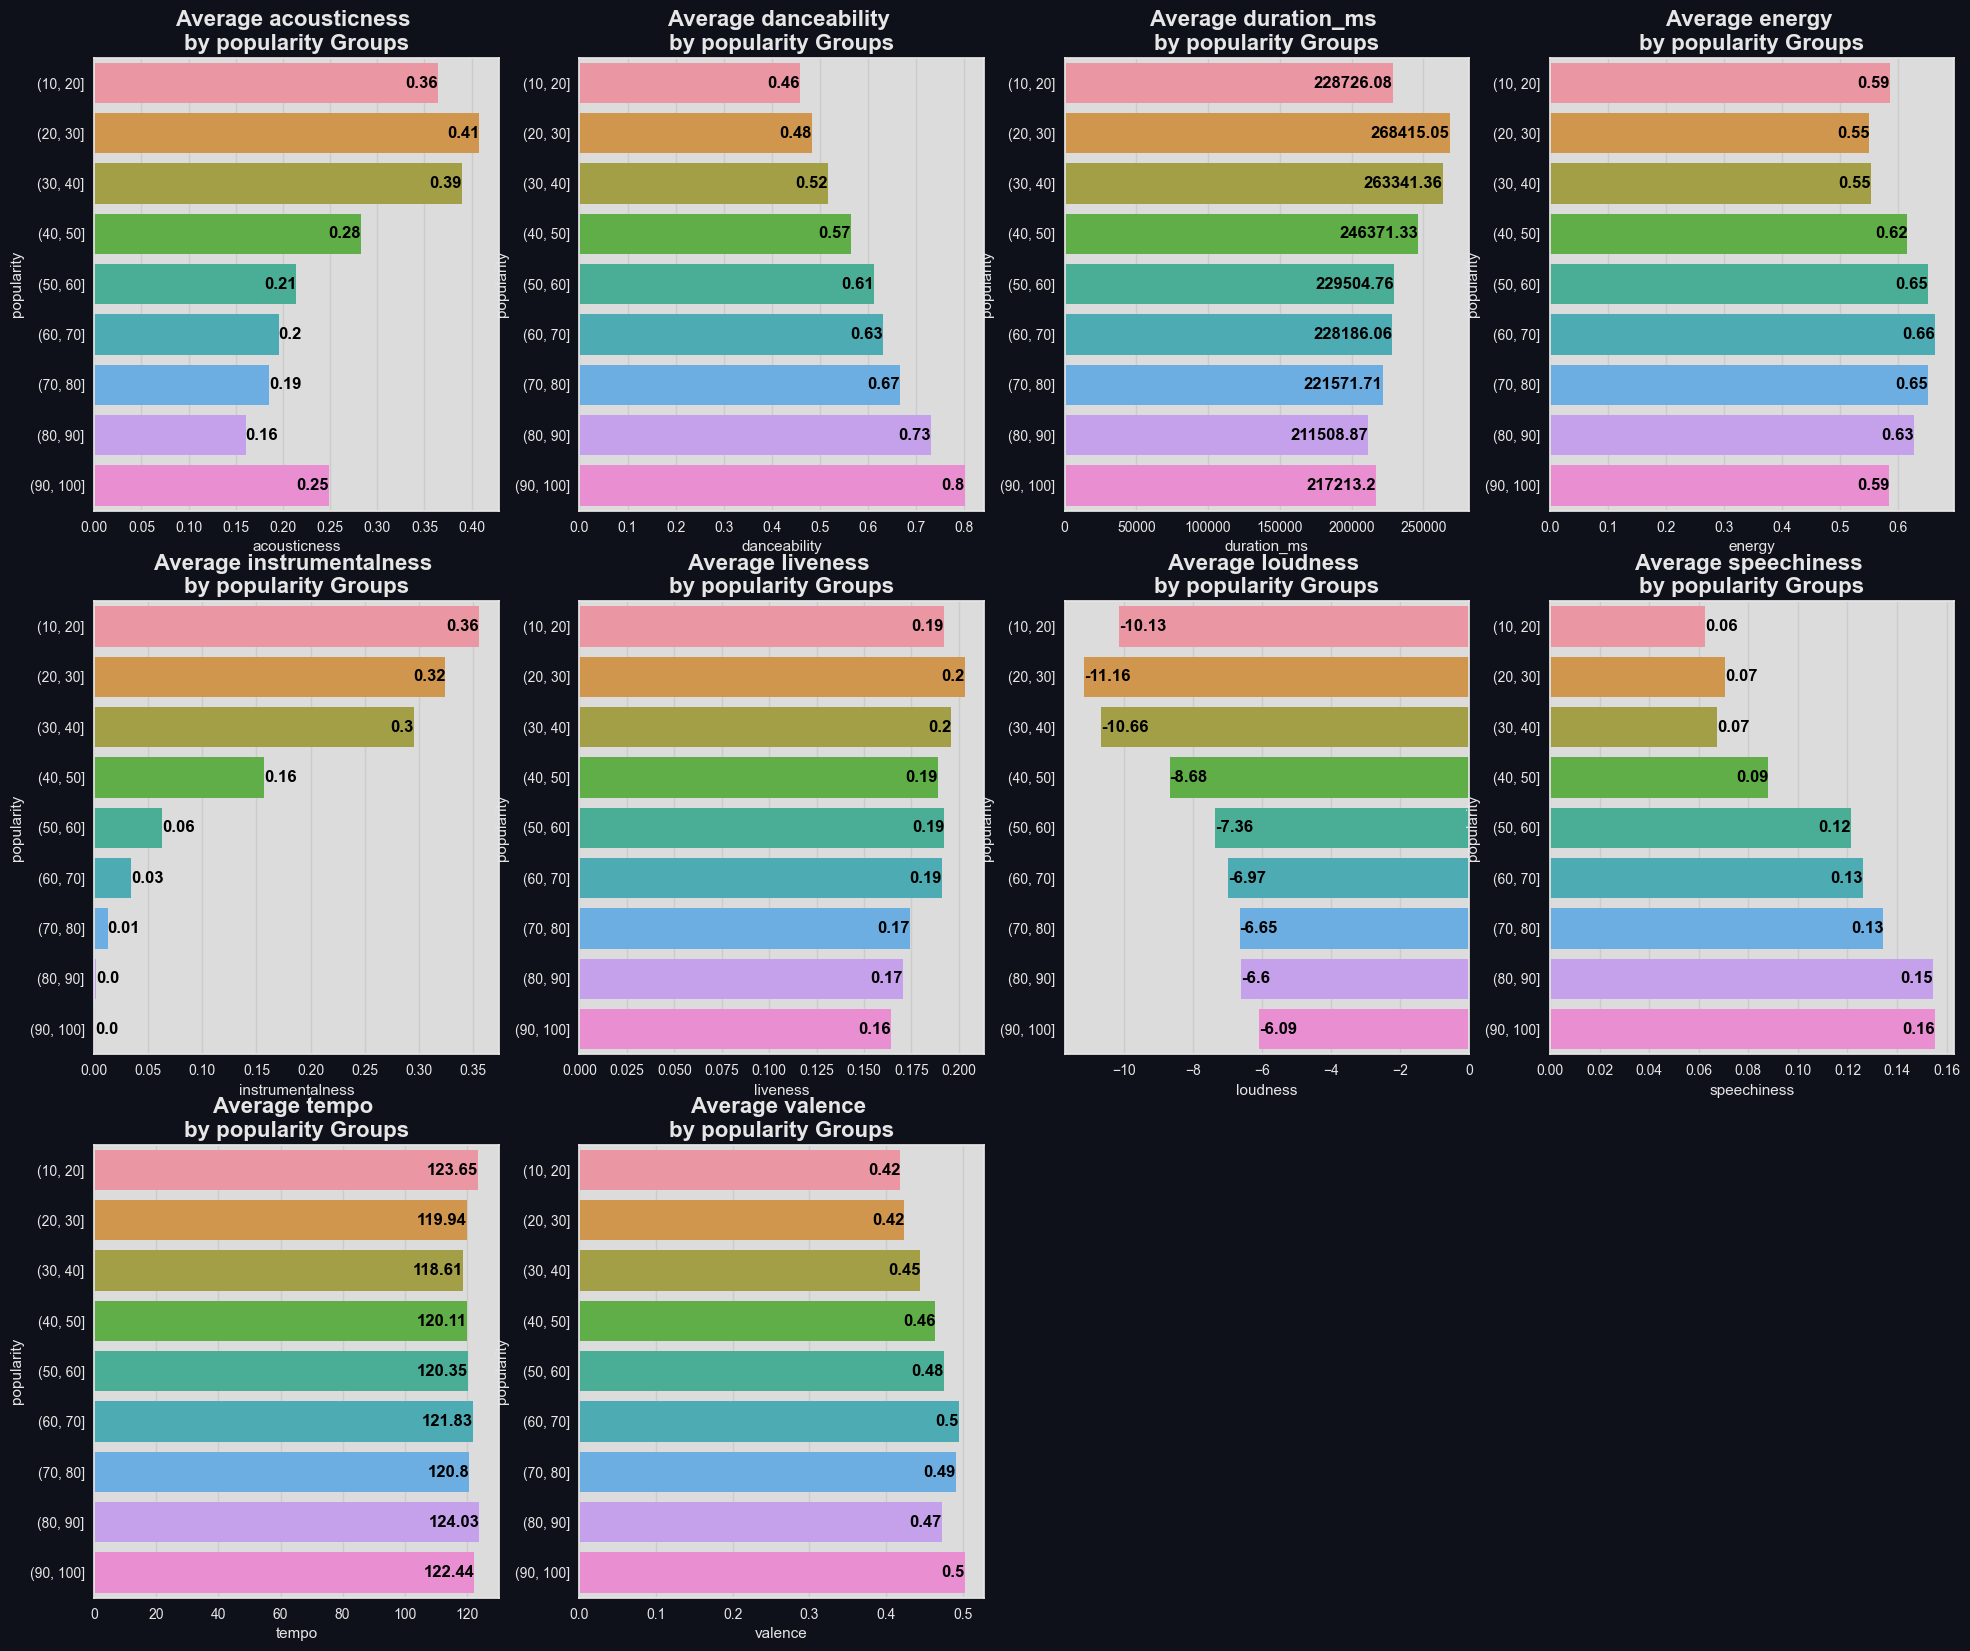

In [20]:
featureByPopularityPlot = visualizationof2dataAll(df_visual, 'popularity', [10, 20, 30, 40, 50, 60, 70, 80, 90, 100])

จากกราฟเเท่นด้านบน สามารถสรุปได้ดังนี้
- เพลงที่มีความ acousticness สูง จะมีความนิยมต่ำ
- เมื่อเพลงมีความ danceability สูง ความนิยมก็จะสูงขึ้นตาม
- เมื่อเพลงใช้เครื่องดนตรีในการบรรเลงเยอะ (instrumentalness) ความนิยมก็จะต่ำลง
- เพลงที่ค่า liveness ต่ำ จะมีความนิยมสูง
- เพลงที่มีความดังของเสียงสูง จะมีความนิยมต่ำ
- เพลงที่มีเสียงนักร้องเป็นส่วนใหญ่ (speechiness) จะมีความนิยมสูง
- ความยาวของเพลง (duration_ms), ความพุ่งของเพลง (energy), จังหวะ (tempo), เเละความสูงของเสียง (valence) ไม่ค่อยมีความสัมพันธ์กับความนิยม

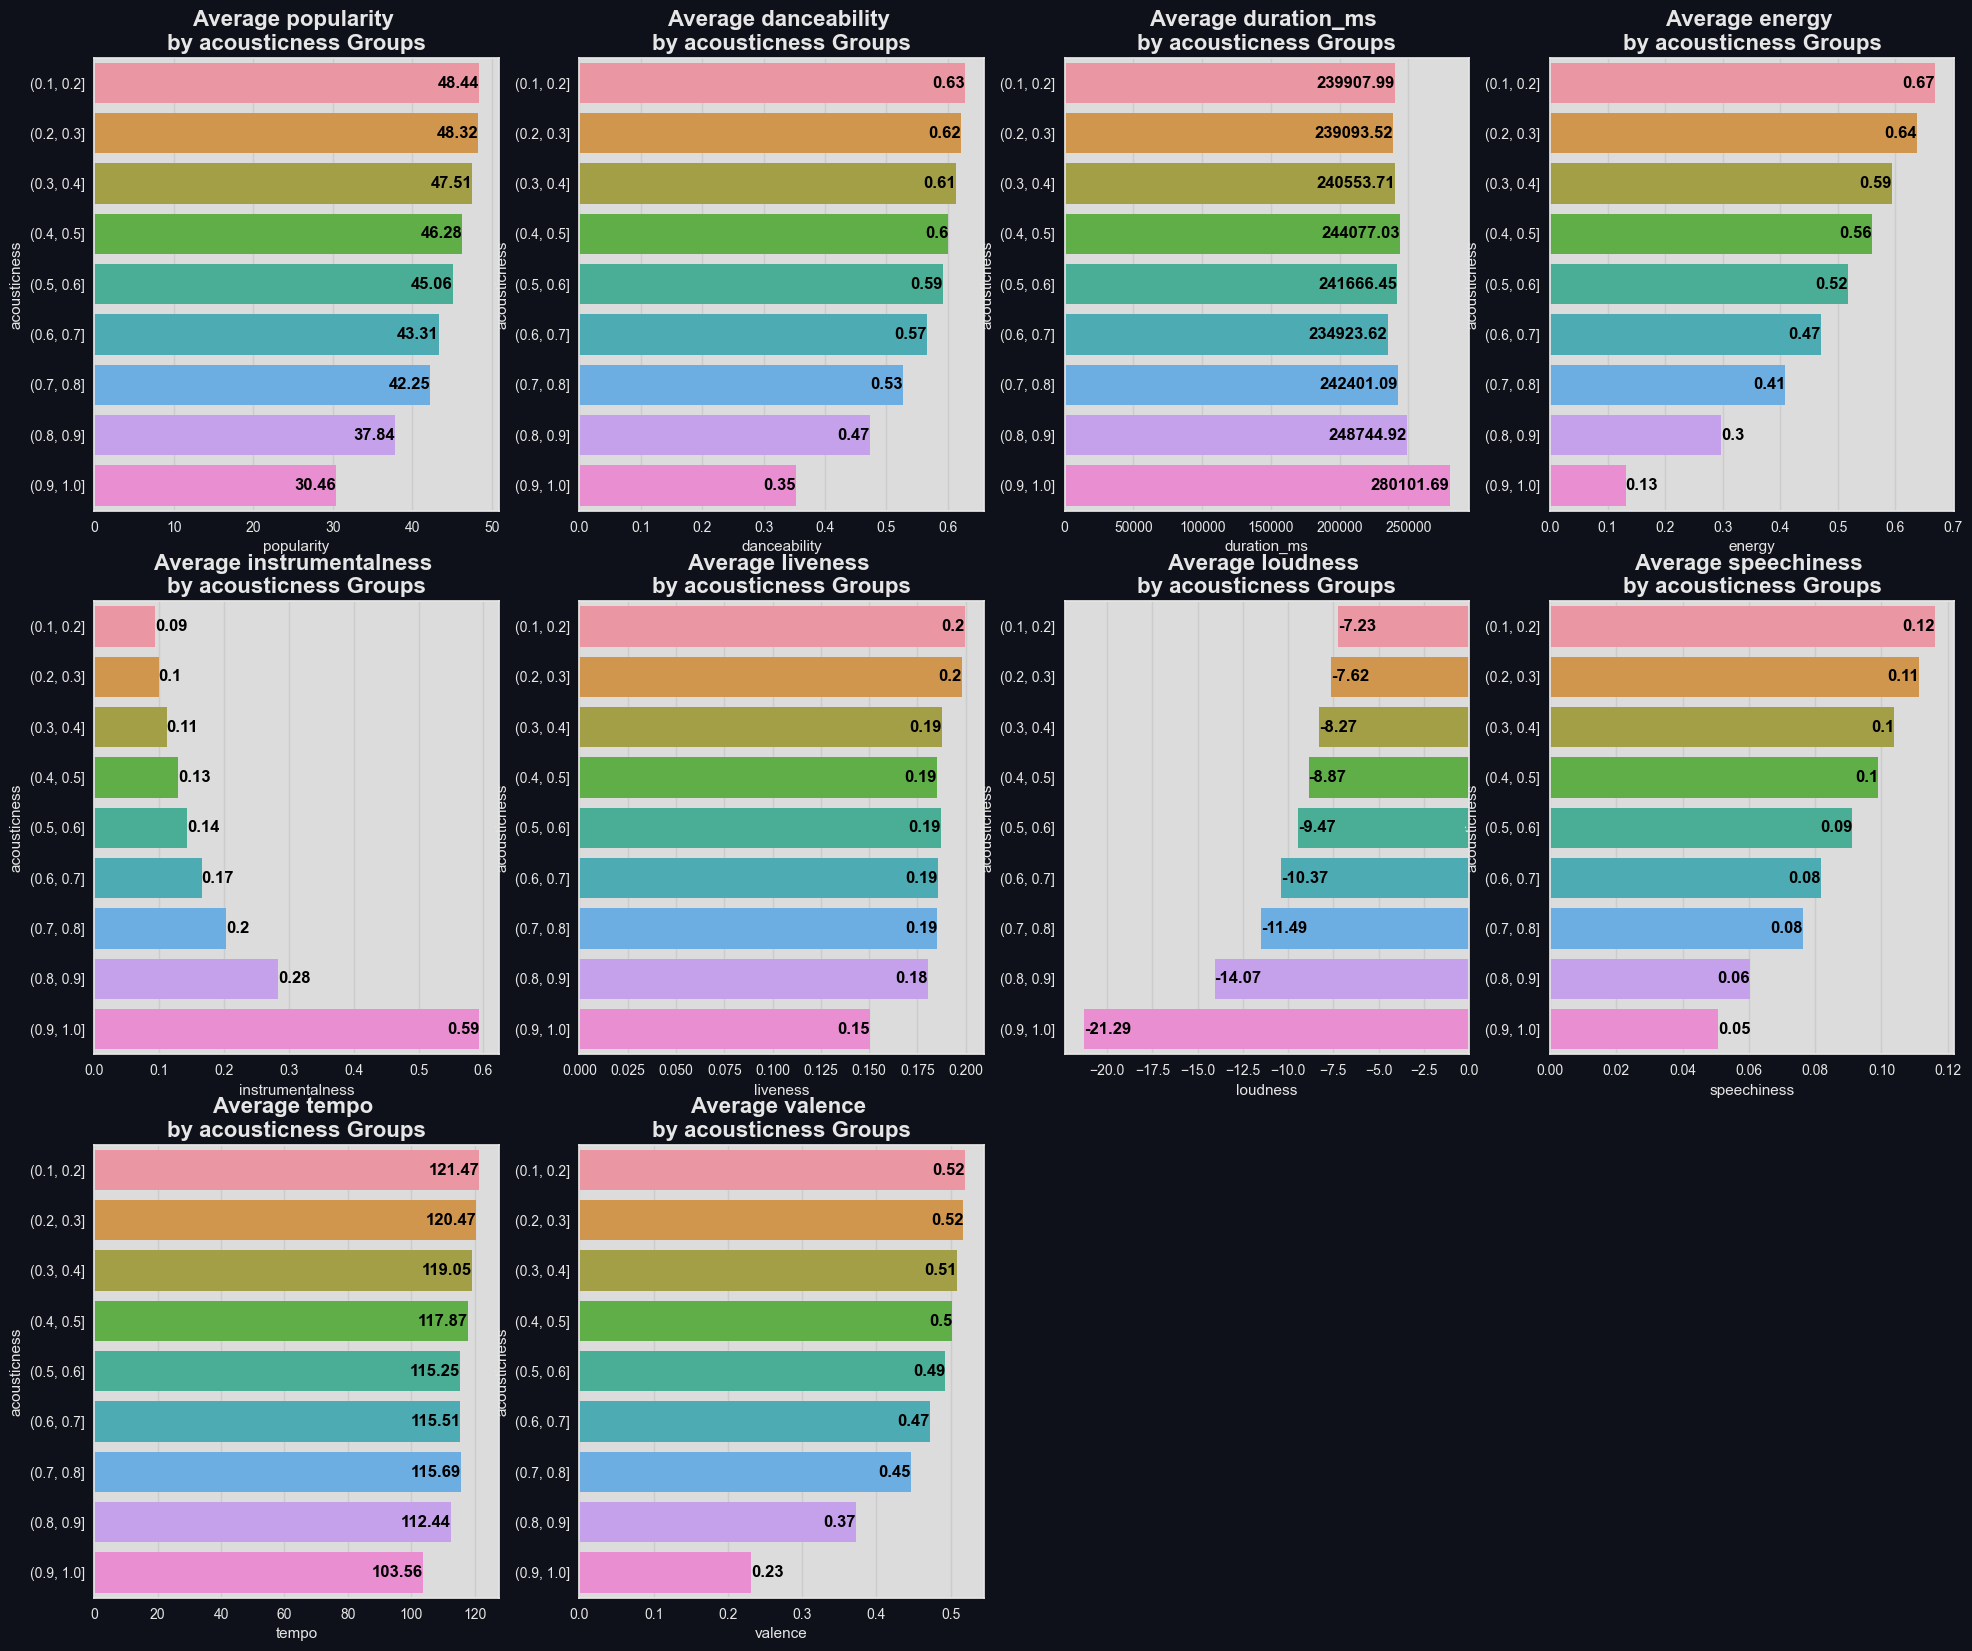

In [21]:
featureByacousticnessPlot = visualizationof2dataAll(df_visual, 'acousticness', [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

จากกราฟเเท่นด้านบน สามารถสรุปได้ดังนี้
- เพลงที่มีความนิยมต่ำ จะมีค่า acousticness สูง
- เมื่อเพลงมีความ danceability สูง ค่า acousticness จะต่ำ
- เมื่อเพลงมีความยาวสูง (duration_ms) ค่า acousticness จะสูง
- เมื่อเพลงมีความพุ่งของเพลง (energy) สูงขึ้น ค่า acousticness จะต่ำลง
- เพลงที่ใช้เครื่องดนตรีในการบรรเลงเยอะ (instrumentalness) ค่า acousticness จะสูง
- เพลงที่ค่า liveness สูง ค่า acousticness จะต่ำ
- เพลงที่เสียงเบา (loudness) ค่า acousticness จะสูง
- เมื่อเพลงที่มีเสียงร้องเยอะ (speechiness) ค่า acousticness จะต่ำลง
- เพลงที่มีจังหวะเร็ว (tempo) ค่า acousticness จะต่ำลง
- เพลงที่มีค่า valence สูง ค่า acousticness จะต่ำลง

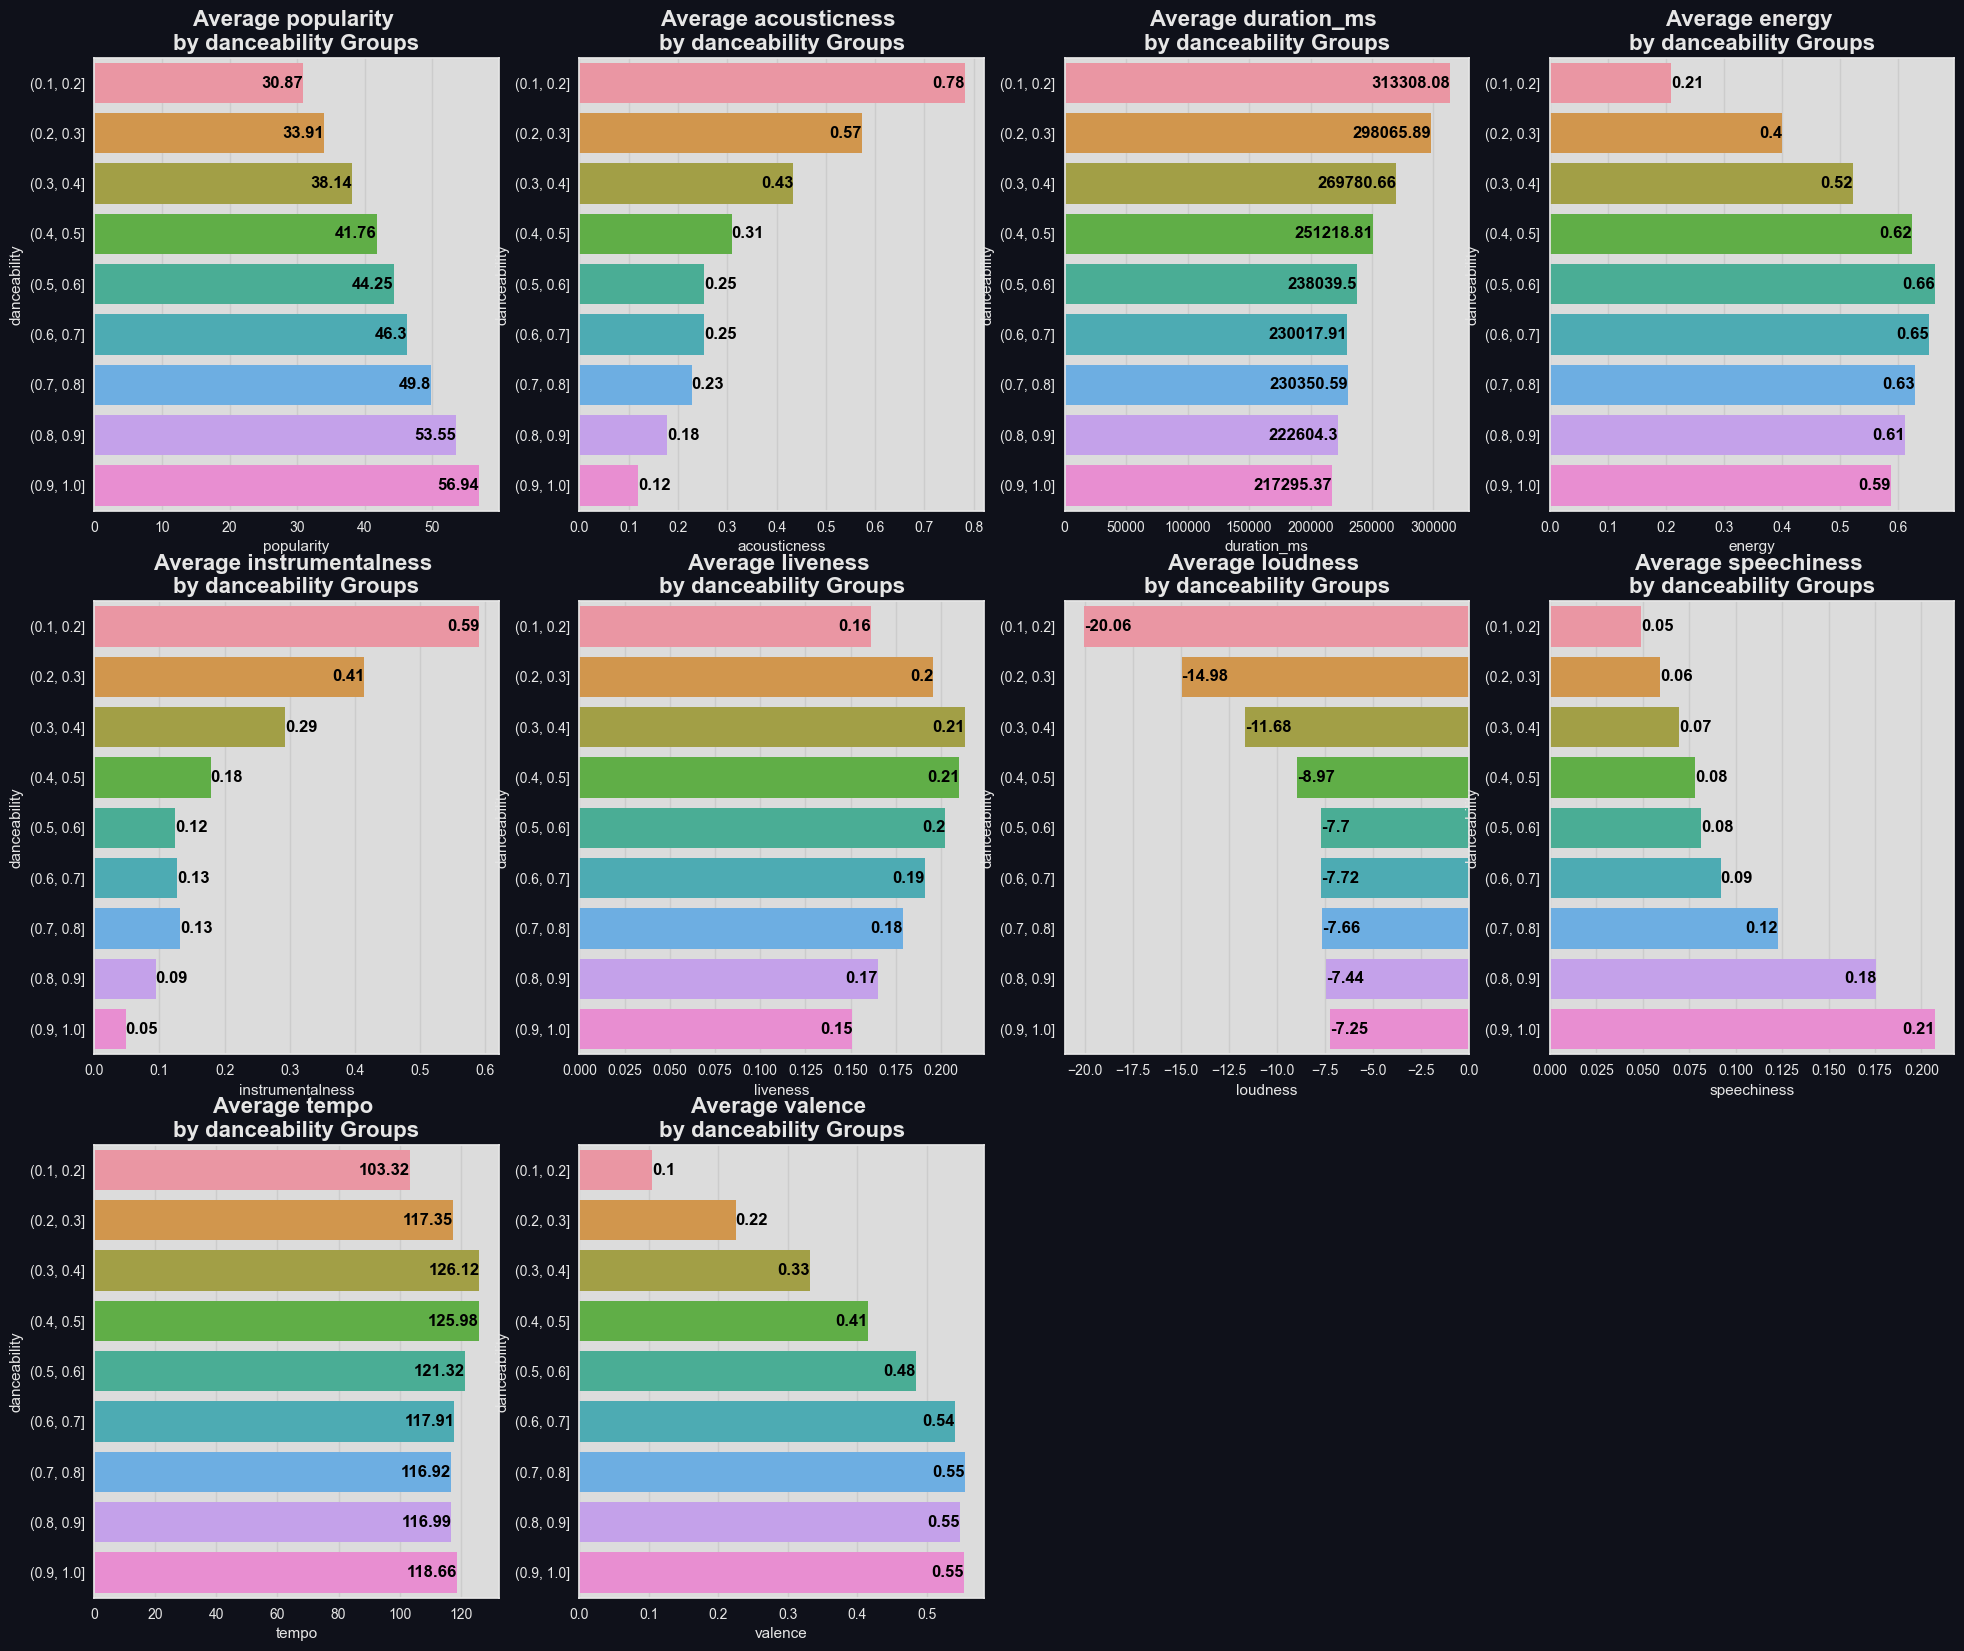

In [23]:
featureBydanceabilityPlot = visualizationof2dataAll(df_visual, 'danceability', [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

จากกราฟเเท่นด้านบน สามารถสรุปได้ดังนี้
- เพลงที่มีความนิยมสูง จะมีค่า danceability สูง
- เมื่อเพลงมีความ danceability สูง ค่า acousticness จะต่ำ
- เมื่อเพลงมีความยาวสูง (duration_ms) ค่า danceability จะต่ำ
- เพลงที่ใช้เครื่องดนตรีในการบรรเลงเยอะ (instrumentalness) ค่า danceability จะต่ำ
- เพลงที่เสียงเบา (loudness) ค่า danceability จะต่ำ
- เมื่อเพลงที่มีเสียงร้องเยอะ (speechiness) ค่า danceability จะสูงขึ้น
- เพลงที่มีค่า valence สูง ค่า danceability จะสูงตาม
- ความพุ่งของเสียง (energy), เพลงที่บันทึกจากการแสดงสด (liveness), เเละจังหวะ (tempo) ไม่ค่อยมีความสัมพันธ์กับ danceability

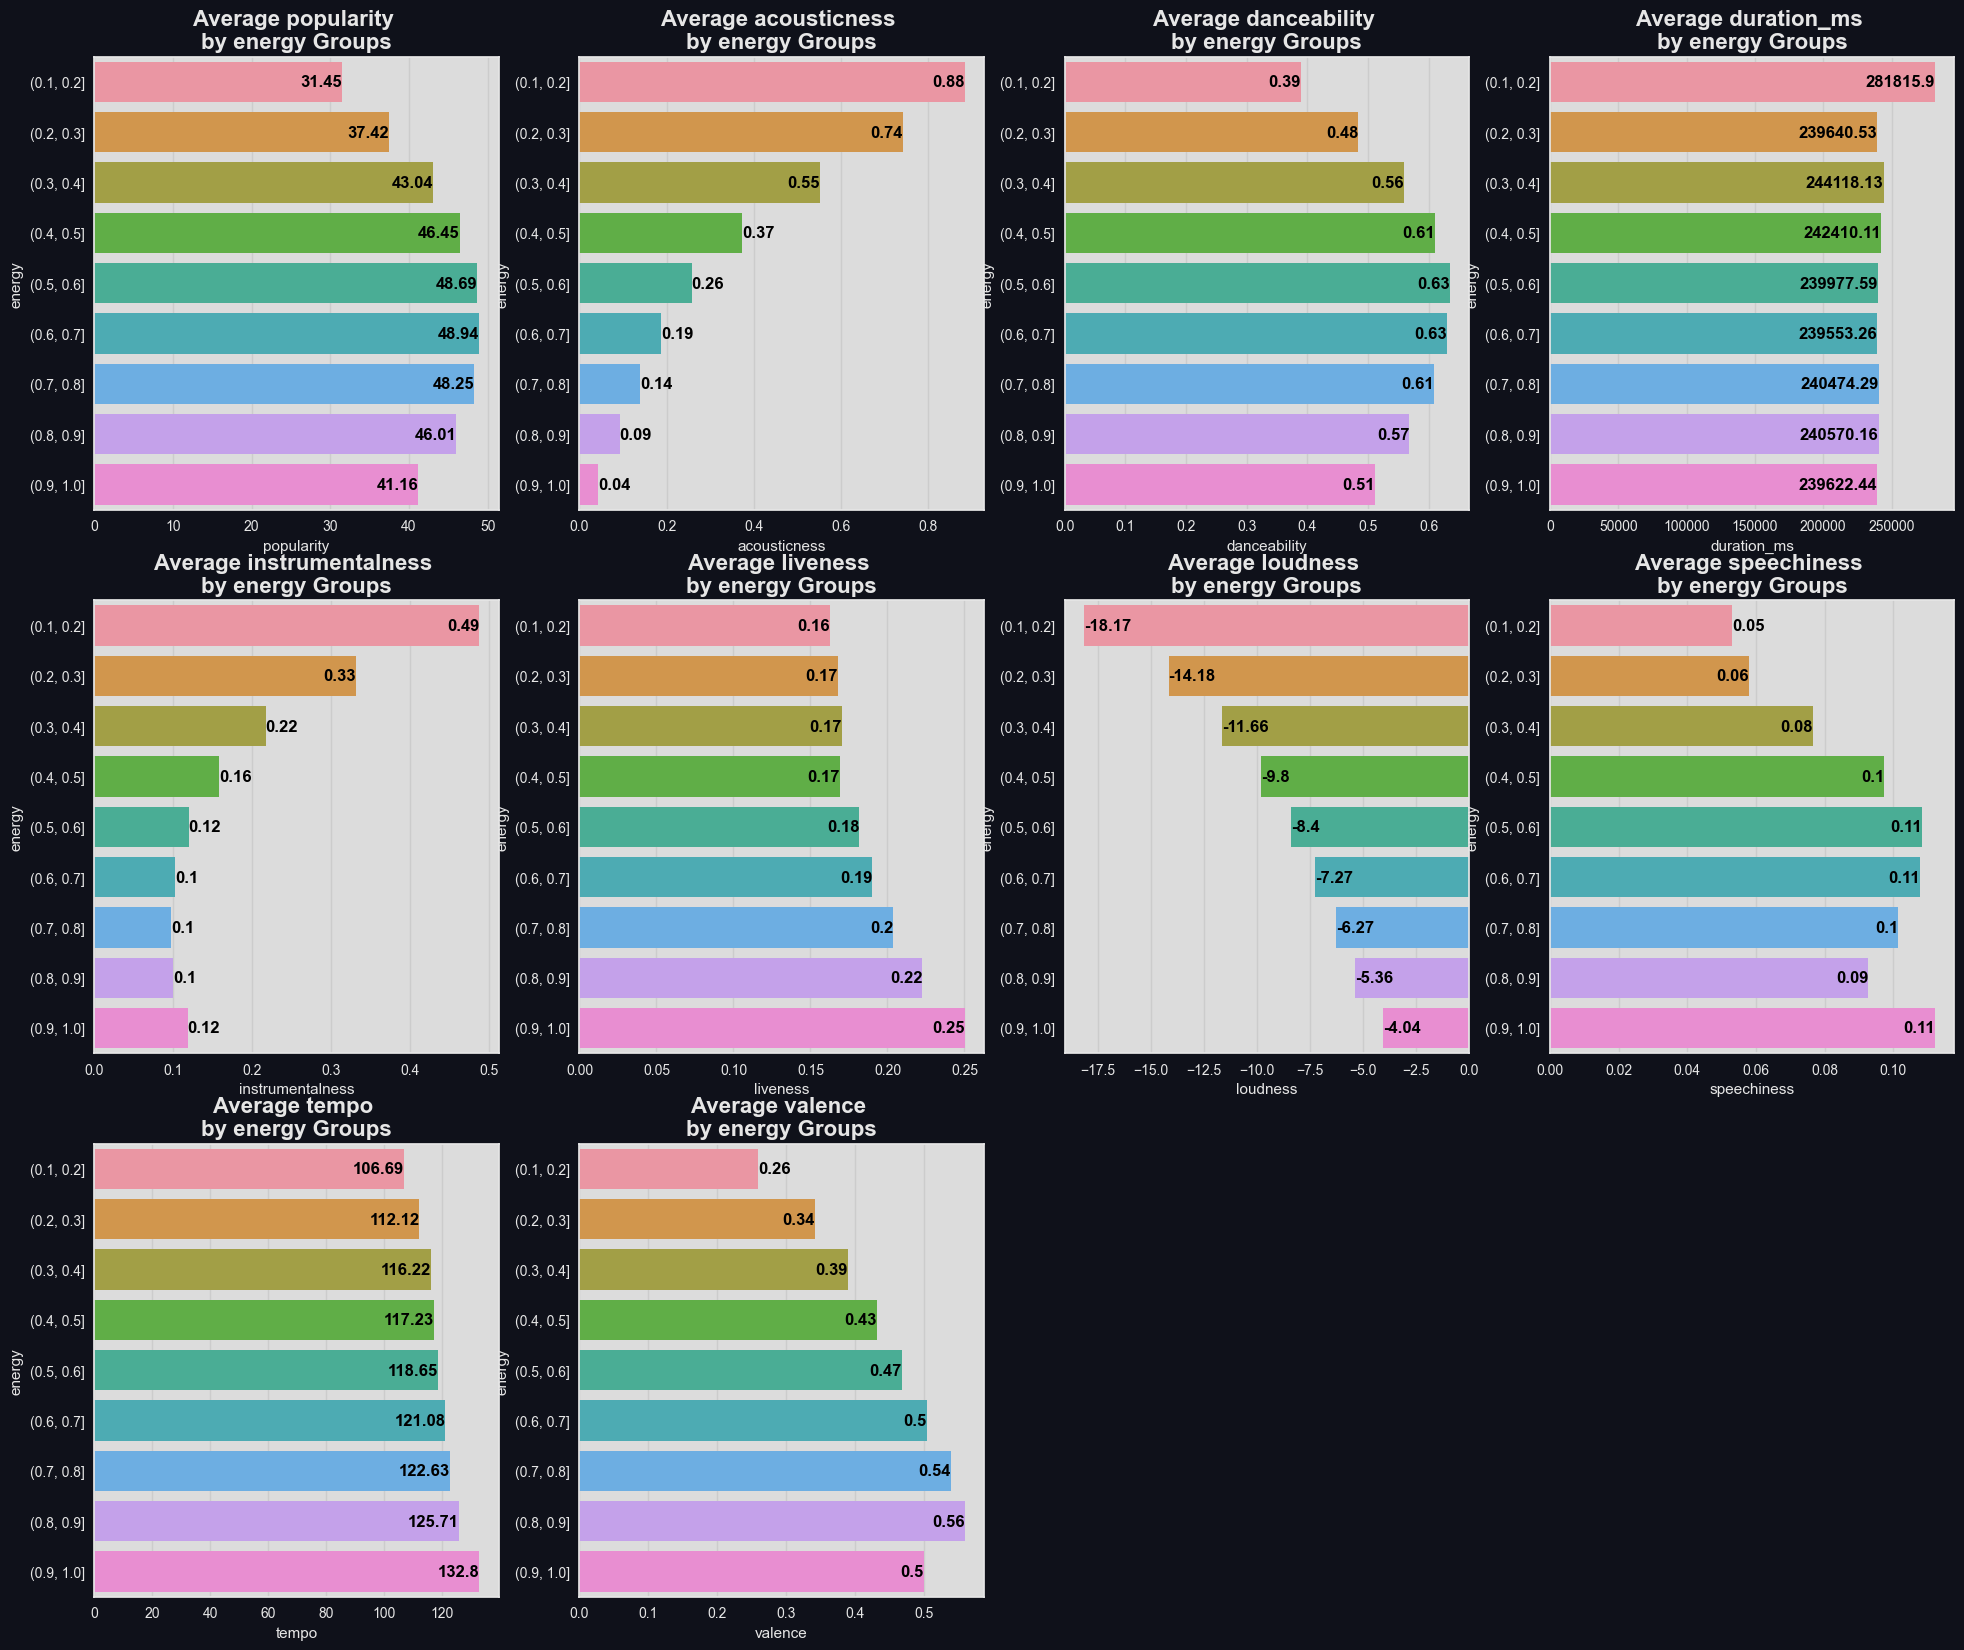

In [24]:
featureByenergyPlot = visualizationof2dataAll(df_visual, 'energy', [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

จากกราฟเเท่นด้านบน สามารถสรุปได้ดังนี้
- เมื่อเพลงมีค่า energy สูง ค่า acousticness จะต่ำ
- เพลงที่ใช้เครื่องดนตรีในการบรรเลงเยอะ (instrumentalness) ค่า energy จะต่ำ
- เพลงที่ค่า liveness สูง ค่า energy จะสูงตาม
- เพลงที่เสียงเบา (loudness) ค่า energy จะต่ำ
- เมื่อเพลงที่มีเสียงร้องเยอะ (speechiness) ค่า energy จะสูง
- เพลงที่มีจังหวะเร็ว (tempo) ค่า energy จะสูง
- เพลงที่มีค่า valence สูง ค่า energy จะสูง
- ความนิยมของเพลง (popularity), ความเต้นของเพลง (danceablity), เเละความยาวของเพลง (duration_ms) ไม่ค่อยมีความสัมพันธ์กับ danceability

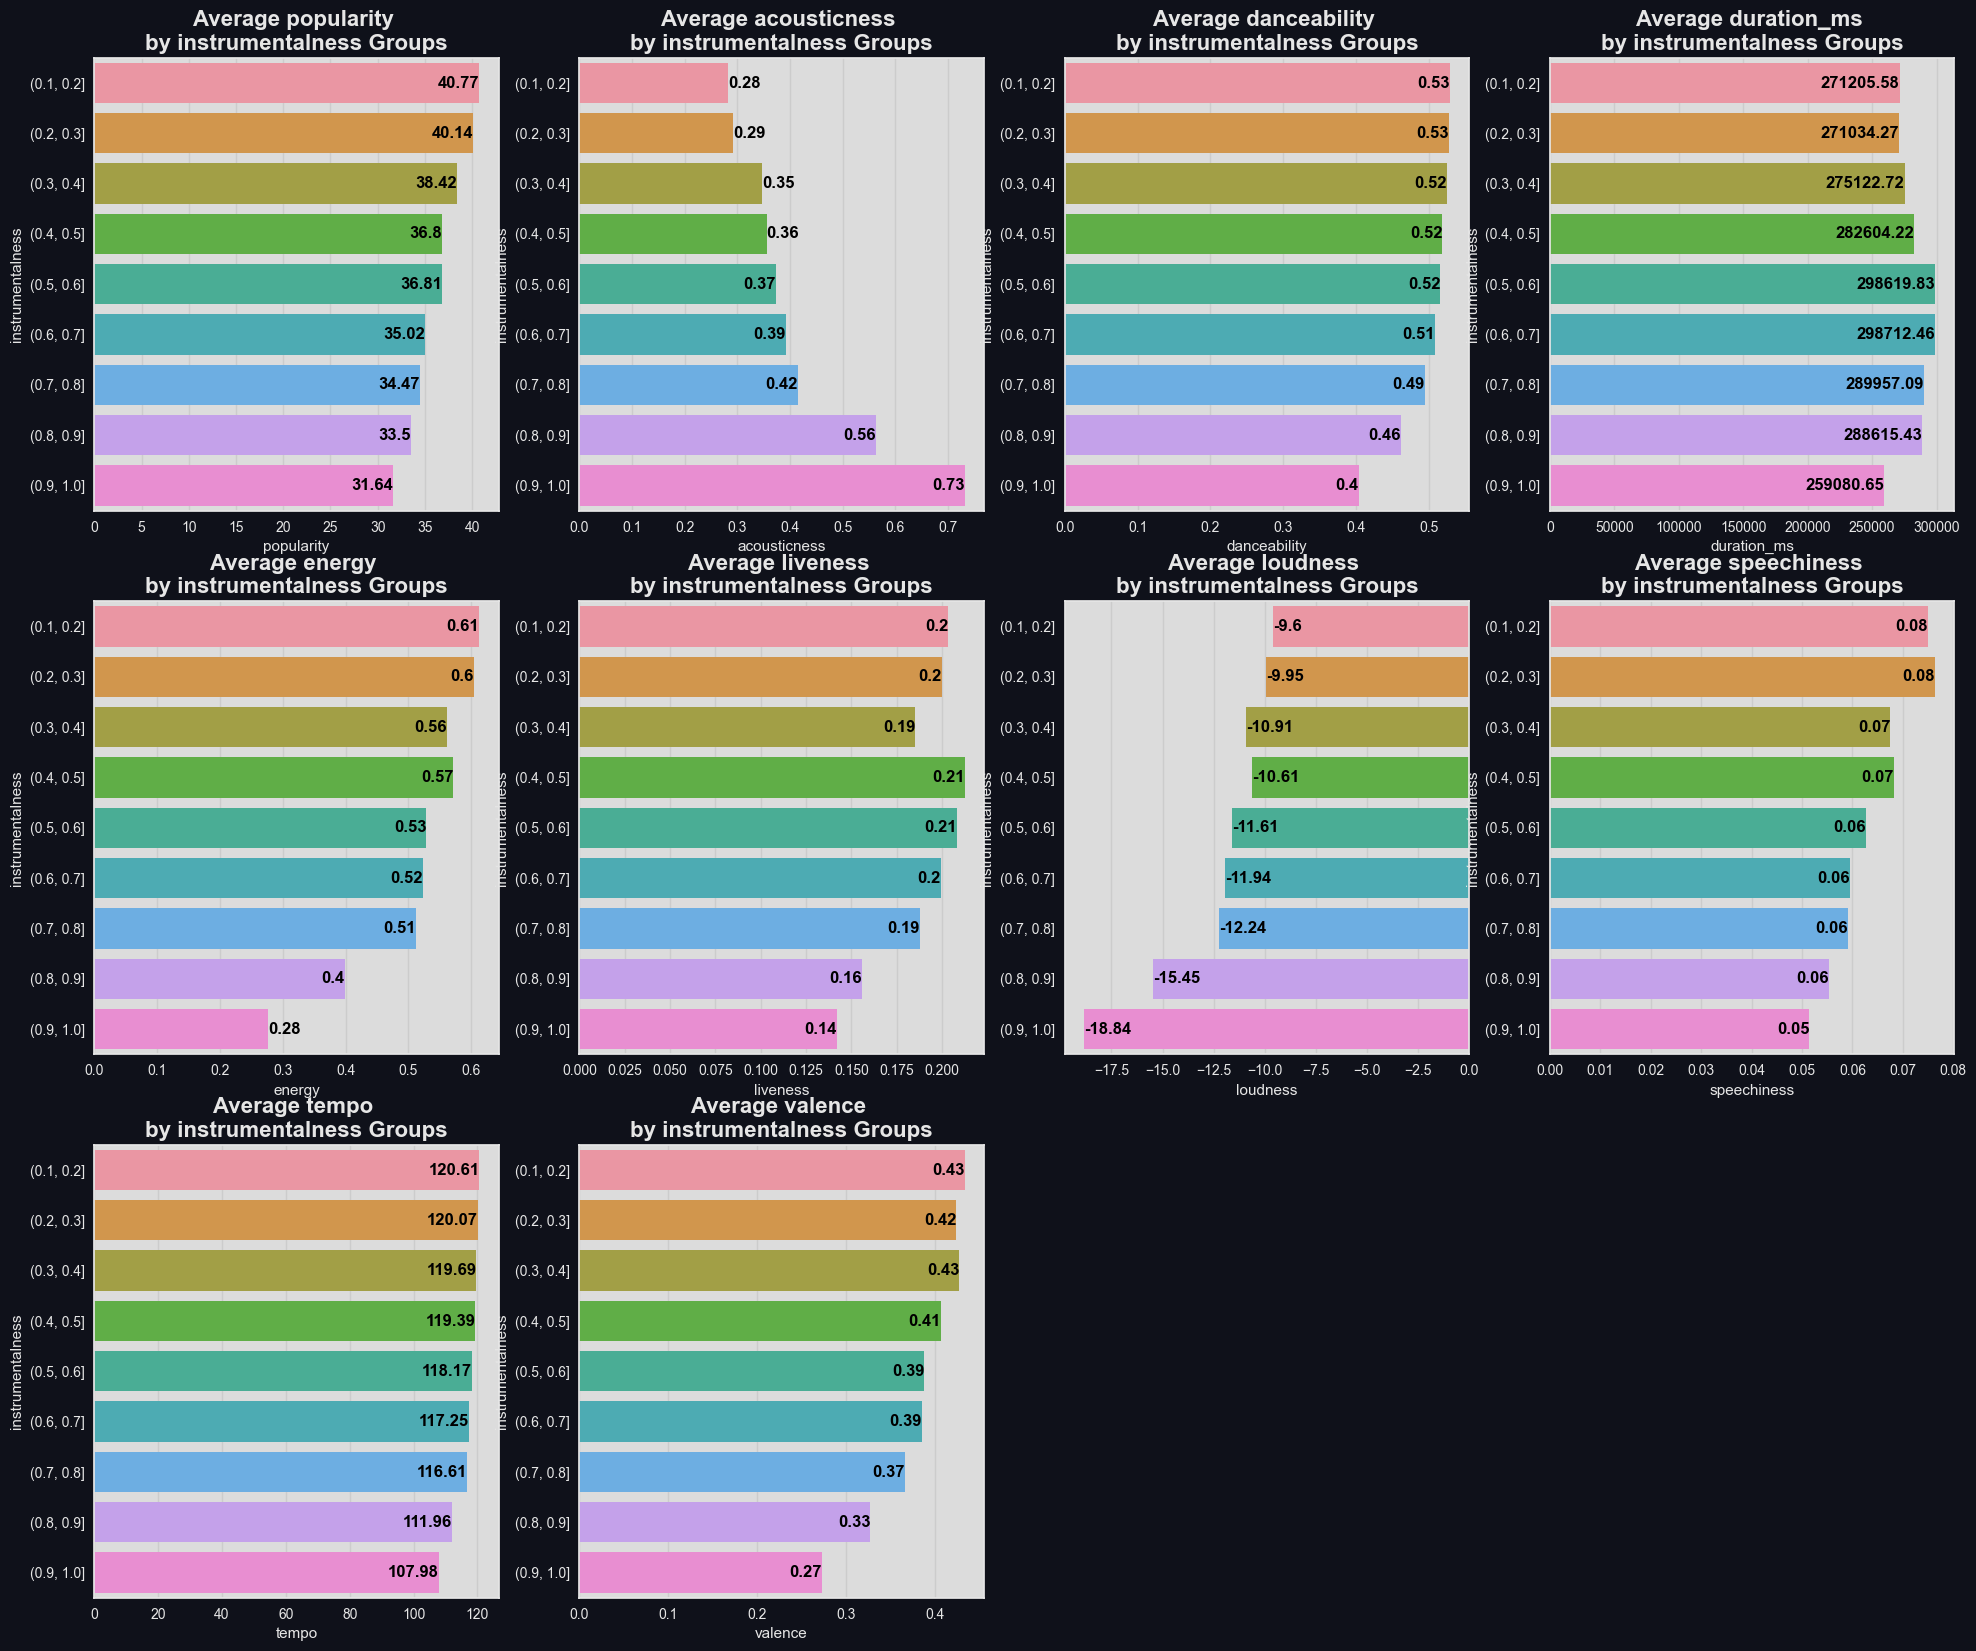

In [25]:
featureByinstrumentalnessPlot = visualizationof2dataAll(df_visual, 'instrumentalness', [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

จากกราฟเเท่นด้านบน สามารถสรุปได้ดังนี้
- เพลงที่มีความนิยมสูง ค่า instrumentalness จะต่ำ
- เพลงที่มีค่า acousticness สูง ค่า instrumentalness จะสูงตาม
- เพลงที่มีค่า danceability สูง ค่า instrumentalness จะต่ำ
- เมื่อเพลงมีค่า energy สูง ค่า instrumentalness จะต่ำ
- เพลงที่เสียงเบา (loudness) ค่า instrumentalness จะสูง
- เมื่อเพลงที่มีเสียงร้องเยอะ (speechiness) ค่า instrumentalness จะต่ำ
- เพลงที่มีจังหวะเร็ว (tempo) ค่า instrumentalness จะต่ำ
- เพลงที่มีค่า valence สูง ค่า instrumentalness จะต่ำ
- ความยาวของเพลง (duration_ms) เเละเพลงที่บันทึกจากการแสดงสด (liveness) ไม่ค่อยมีความสัมพันธ์กับ instrumentalness

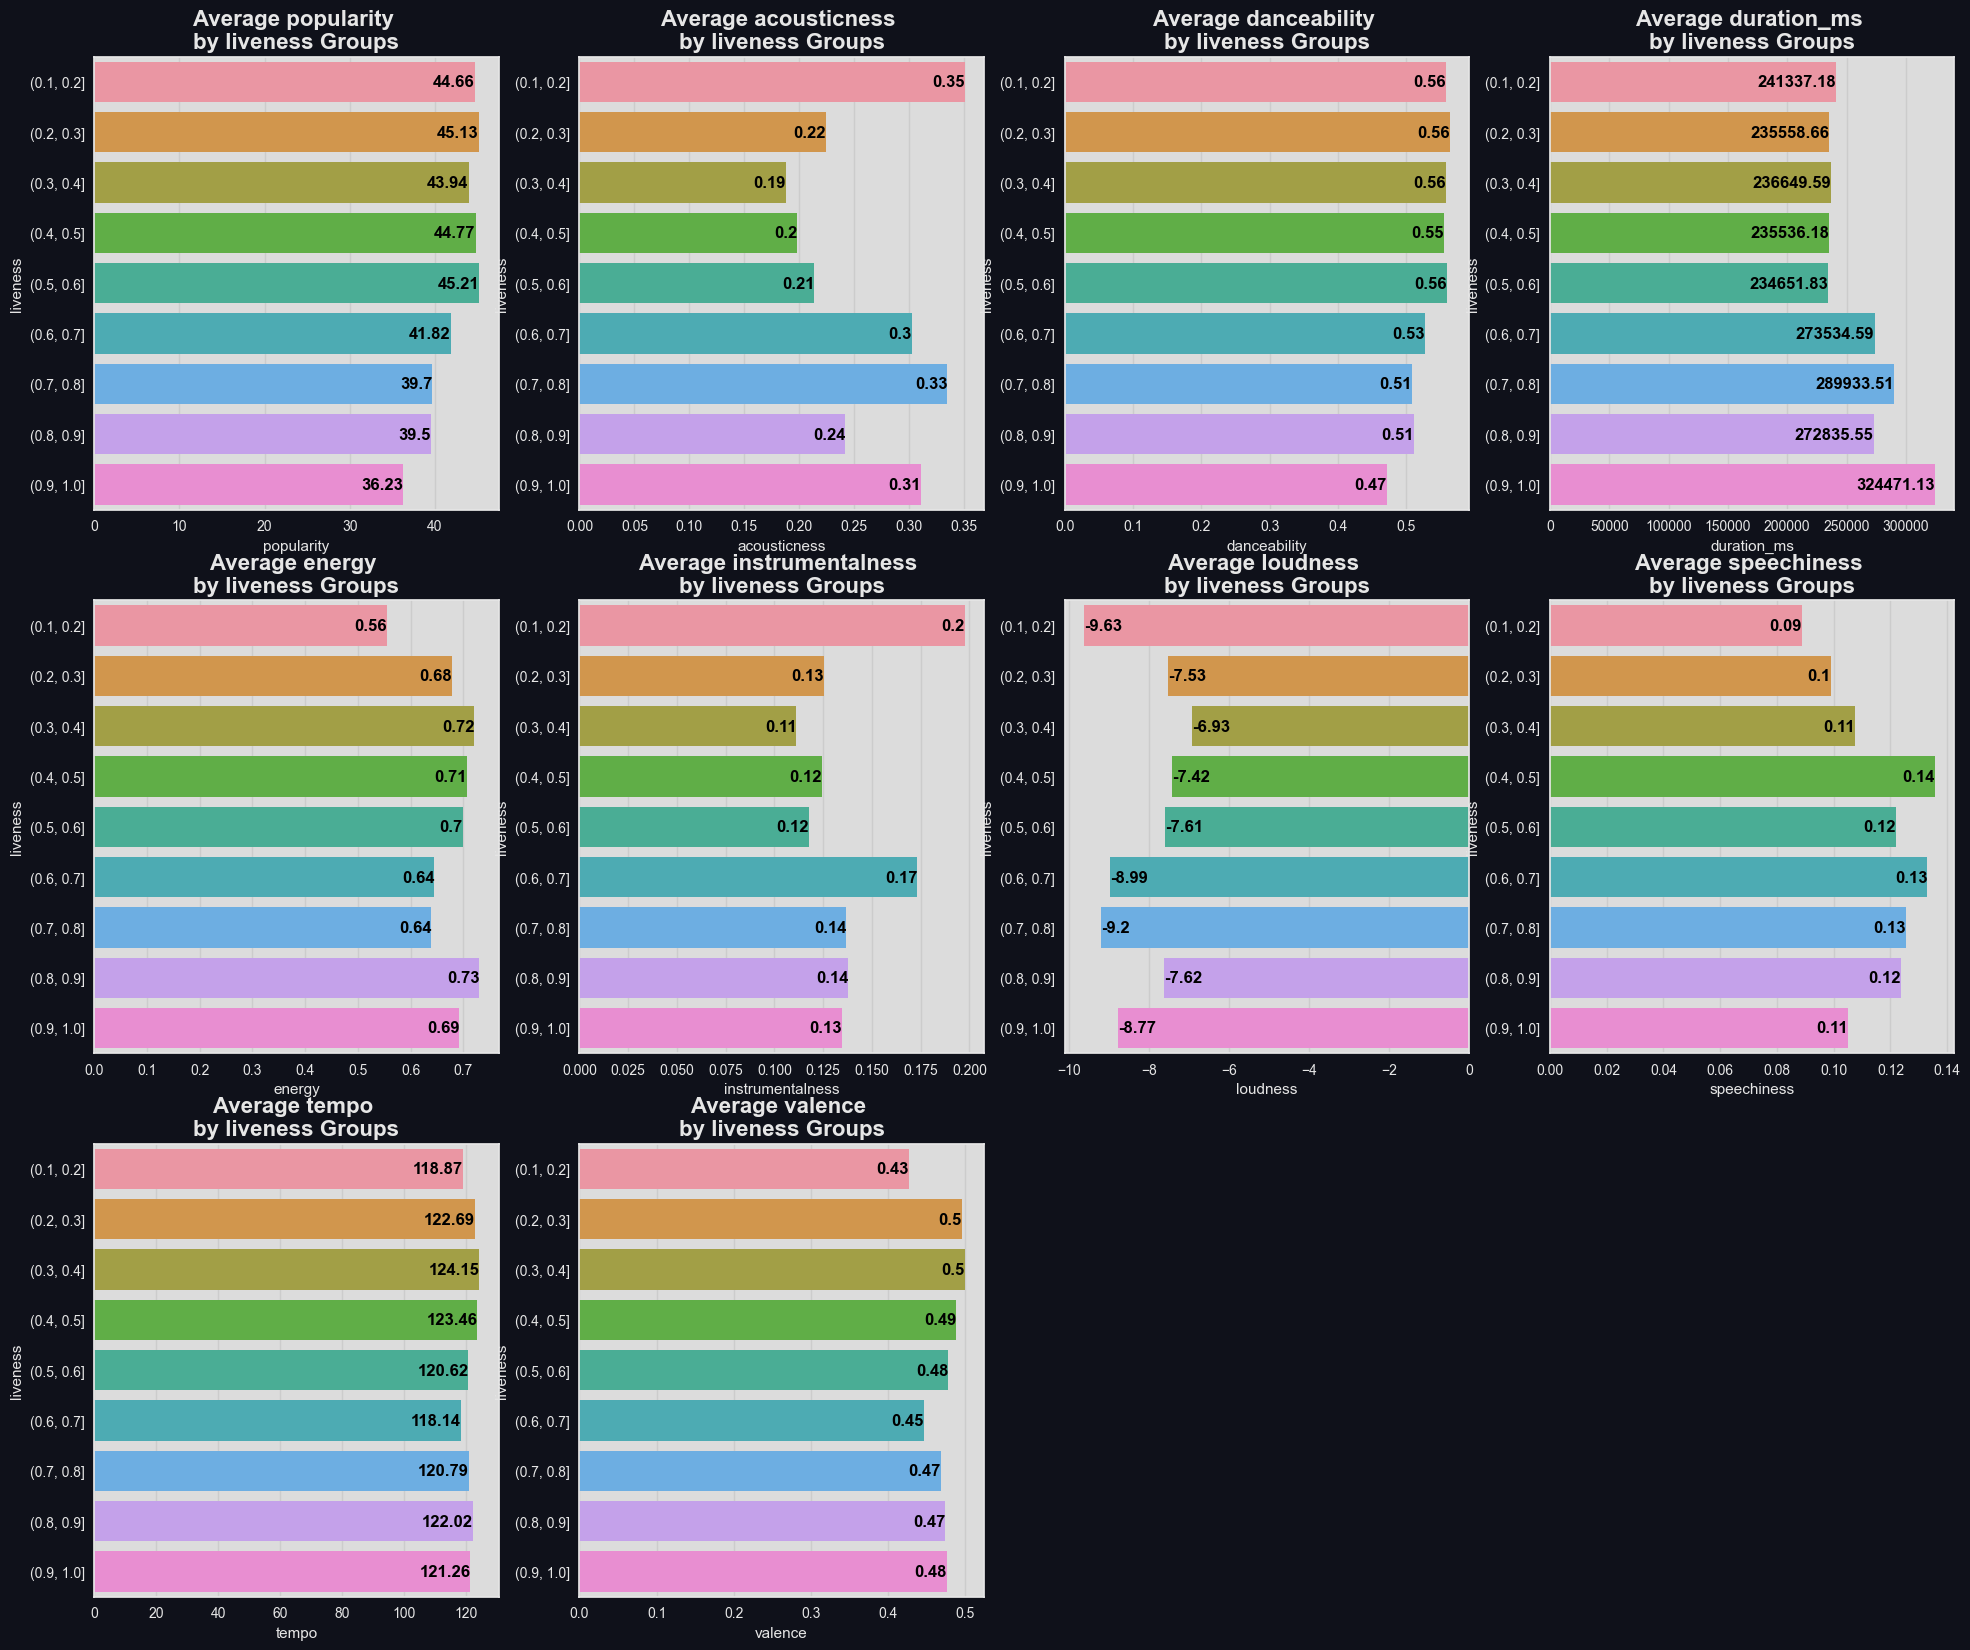

In [27]:
featureBylivenessPlot = visualizationof2dataAll(df_visual, 'liveness', [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

จากกราฟเเท่นด้านบน สามารถสรุปได้ดังนี้
- เพลงที่มีความนิยมสูง ค่า liveness จะต่ำ
- เพลงที่มีค่า danceability ต่ำ ค่า liveness จะสูง
- เพลงที่มีความยาว (duration_ms) สูง ค่า liveness จะสูง
- acousticness, energy, instrumentalness, loudness, speechiness, tempo, เเละ valence ไม่มีค่อยมีความสัมพันธ์กับ liveness

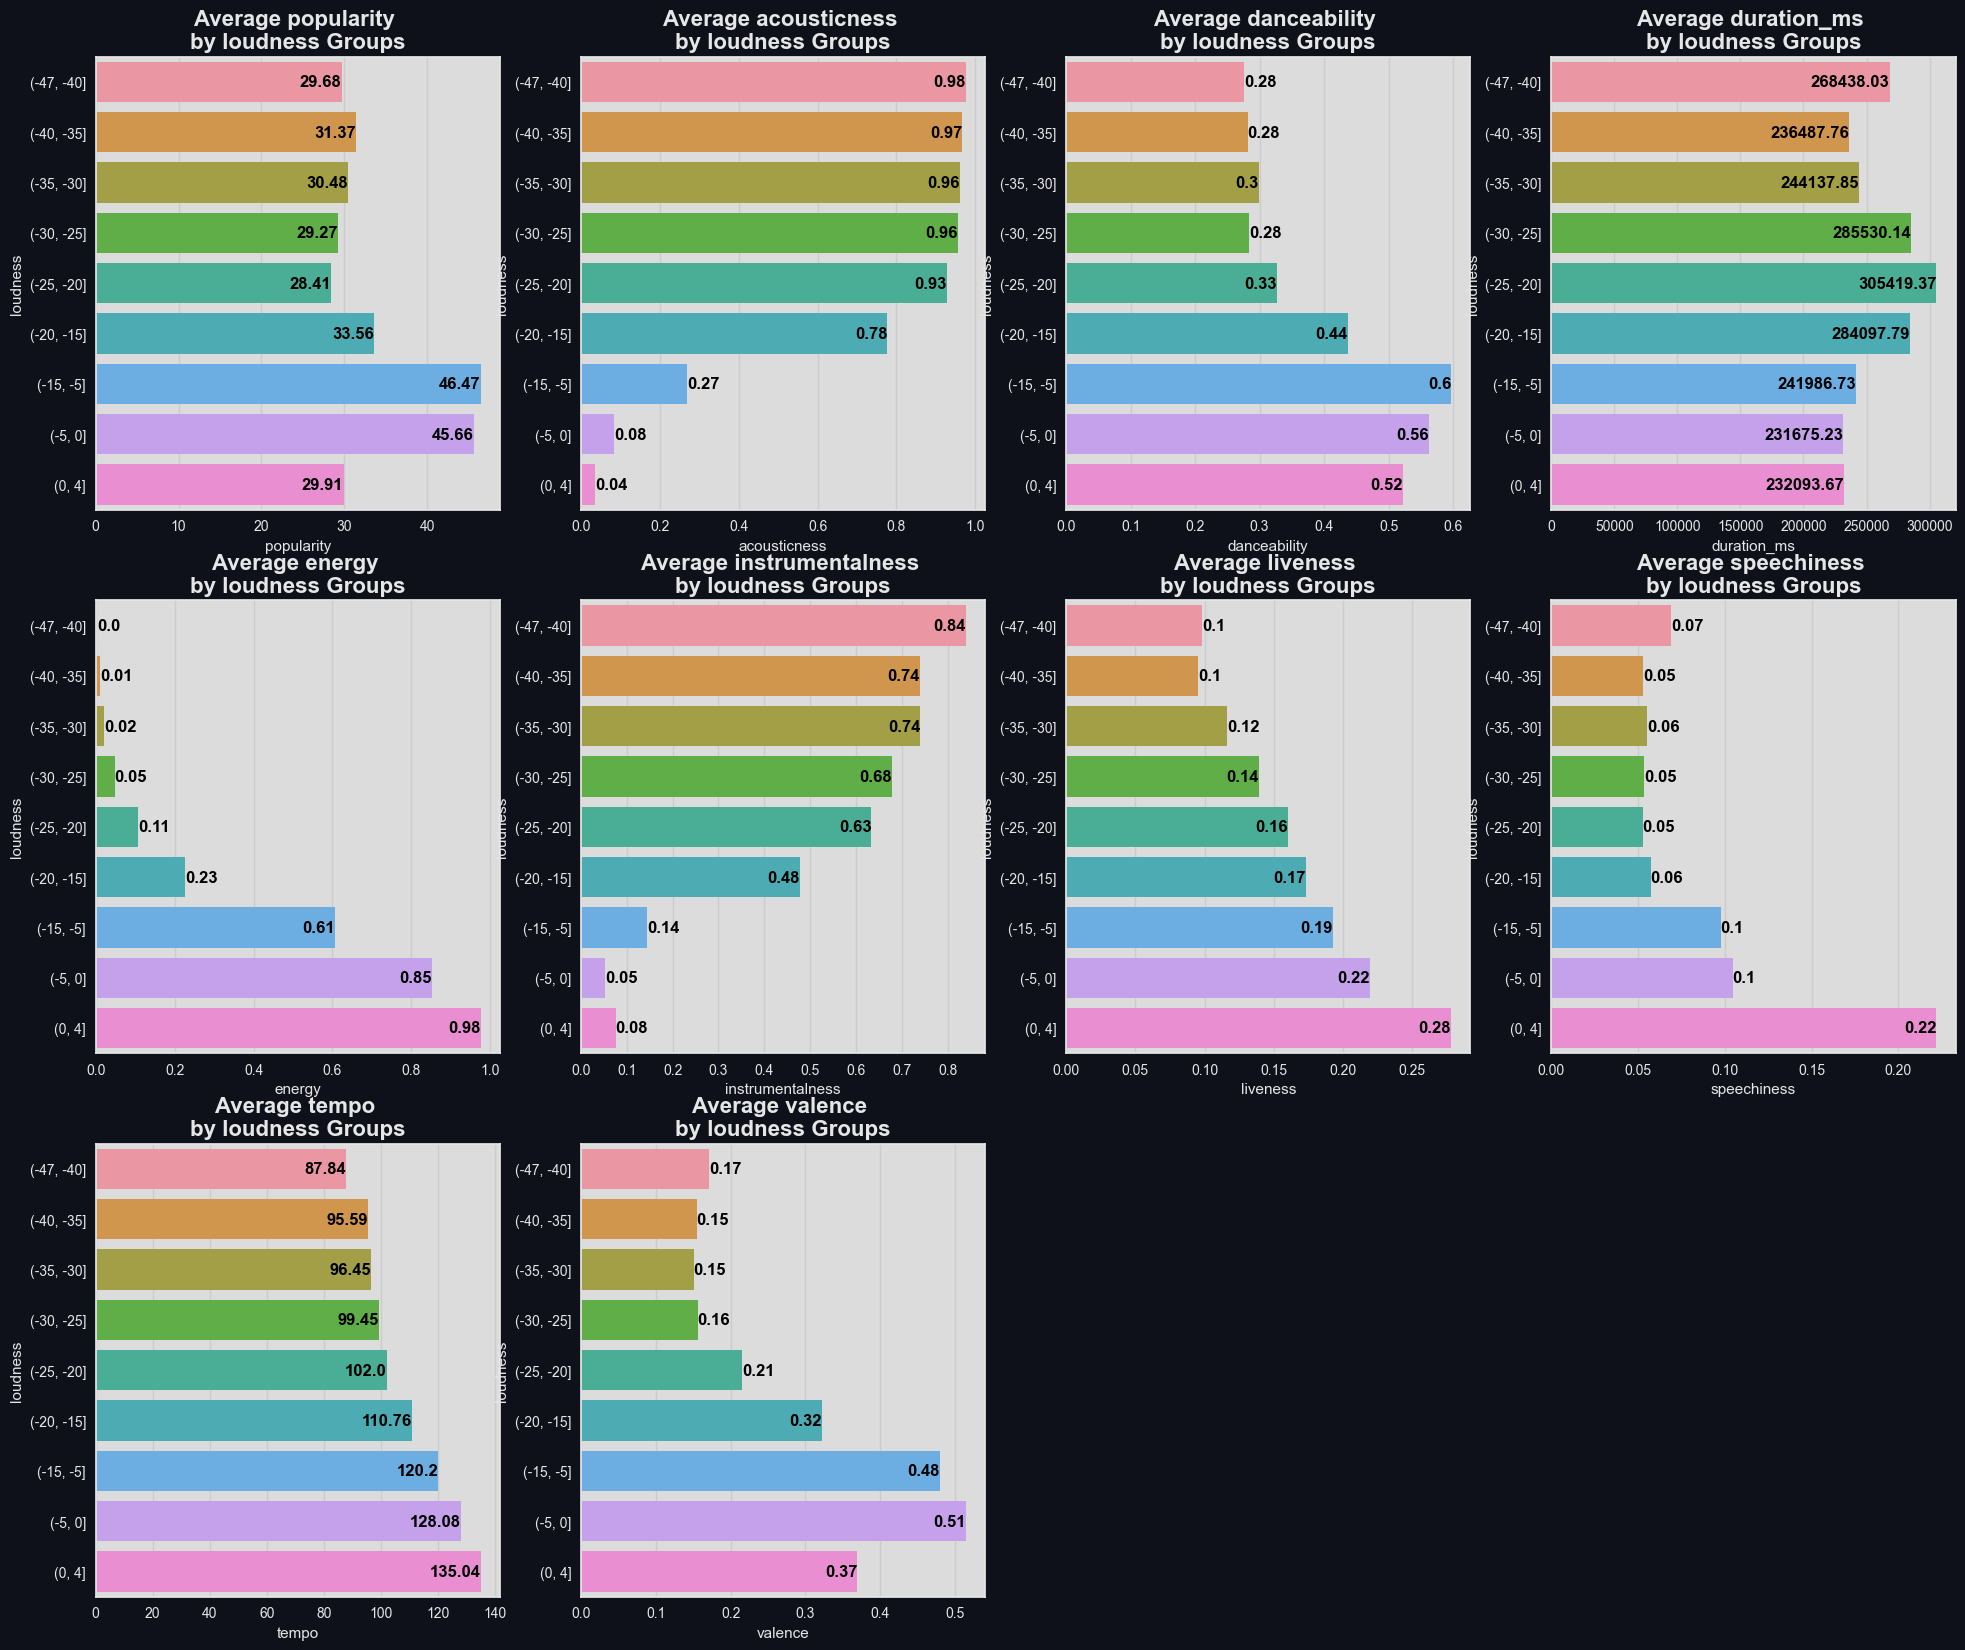

In [28]:
featureByloudnessPlot = visualizationof2dataAll(df_visual, 'loudness', [-47, -40, -35, -30, -25, -20, -15, -5, 0, 4])

จากกราฟเเท่นด้านบน สามารถสรุปได้ดังนี้
- เพลงที่มีค่า acousticness ต่ำ ความดังของเสียงก็จะสูง
- เพลงที่มีค่า danceability สูง ความดังของเสียงก็จะสูง
- เมื่อเพลงมีค่า energy สูง ความดังของเสียงก็จะสูงตาม
- เพลงที่ใช้เครื่องดนตรีในการบรรเลงเยอะ (instrumentalness) ความดังของเสียงก็จะต่ำ
- เพลงที่ค่า liveness สูง ความดังของเสียงก็จะสูง
- เพลงที่มีเสียงร้องเยอะ (speechiness) ความดังของเสียงก็จะสูง
- เพลงที่มีจังหวะเร็ว (tempo) ความดังของเสียงก็จะสูงขึ้นตาม
- เพลงที่มีค่า valence สูง ความดังของเสียงก็จะสูง
- ความนิยมของเพลง (popularity) เเละความยาวของเพลง (duration_ms) ไม่ค่อยมีความสัมพันธ์กับ loudness

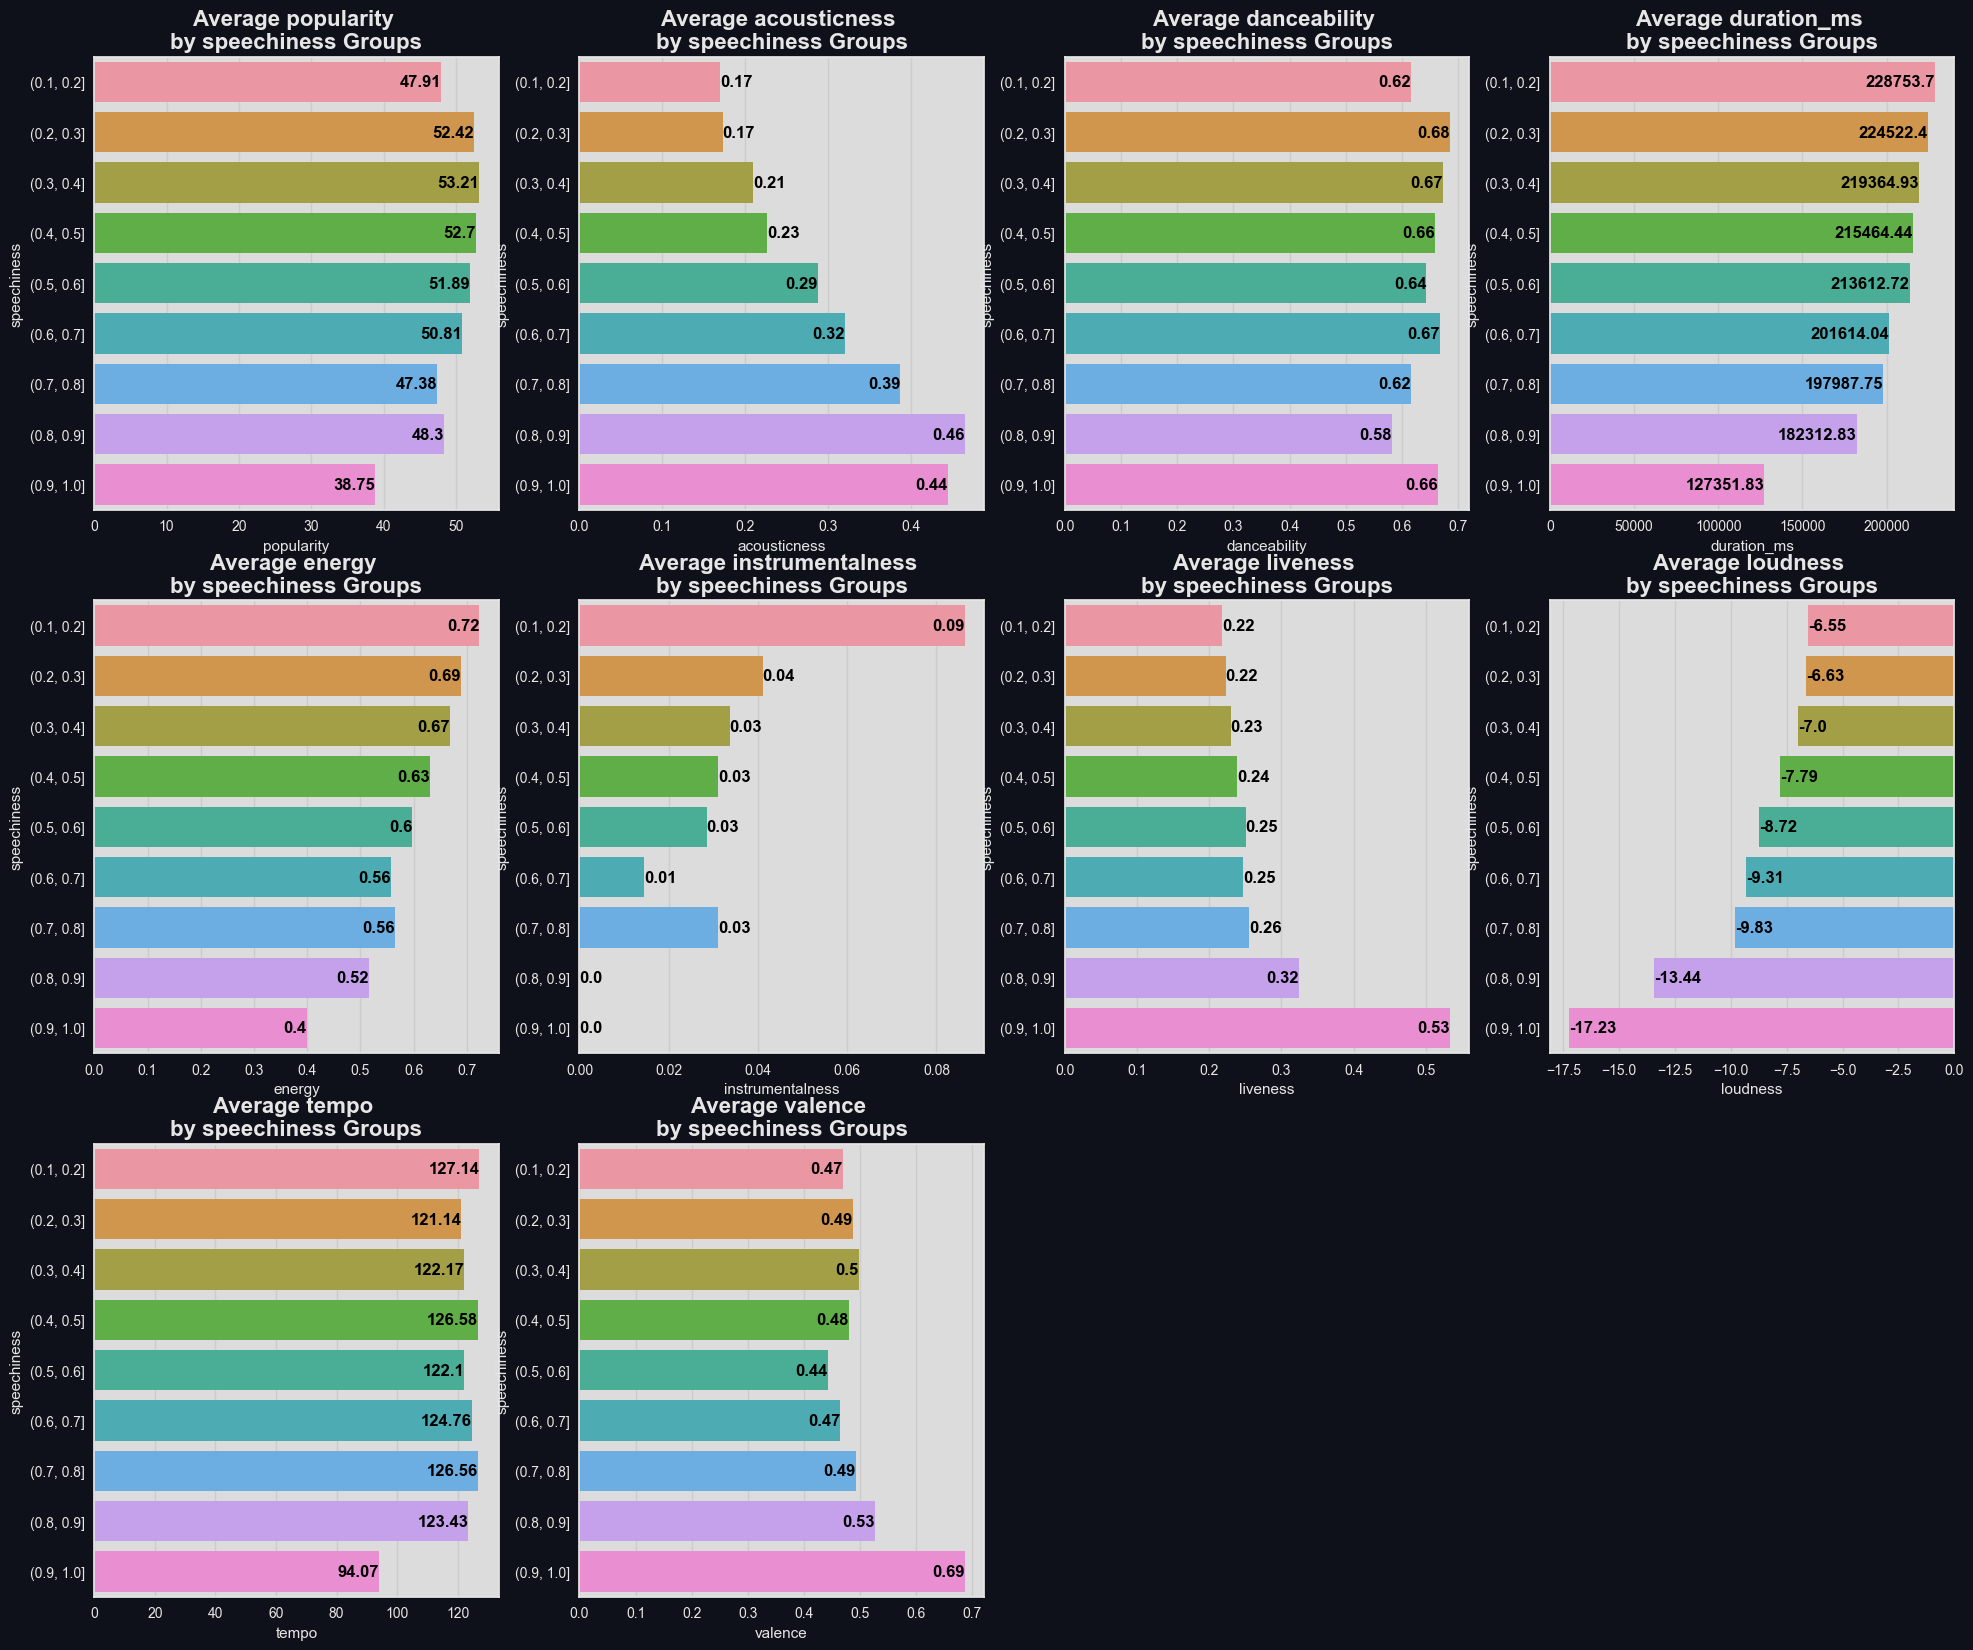

In [29]:
featureByspeechinessPlot = visualizationof2dataAll(df_visual, 'speechiness', [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

จากกราฟเเท่นด้านบน สามารถสรุปได้ดังนี้
- เพลงที่มีค่า acousticness สูง ค่า speechiness ก็จะสูง
- เพลงที่มีความยาวต่ำ ค่า speechiness ก็จะสูง
- เมื่อเพลงมีค่า energy สูง ค่า speechiness จะต่ำลง
- เพลงที่ใช้เครื่องดนตรีในการบรรเลงเยอะ (instrumentalness) ค่า speechiness จะต่ำ
- เพลงที่ค่า liveness สูง ค่า speechiness จะสูงขึ้นตาม
- เพลงที่มีเสียงดัง (loudness) ค่า speechiness จะลดต่ำลง ????
- ความนิยมของเพลง (popularity), ความเต้นของเพลง (danceablity), จังหวะเพลง (tempo), เเละความสูงของเสียง (valence) ไม่ค่อยมีความสัมพันธ์กับ speechiness

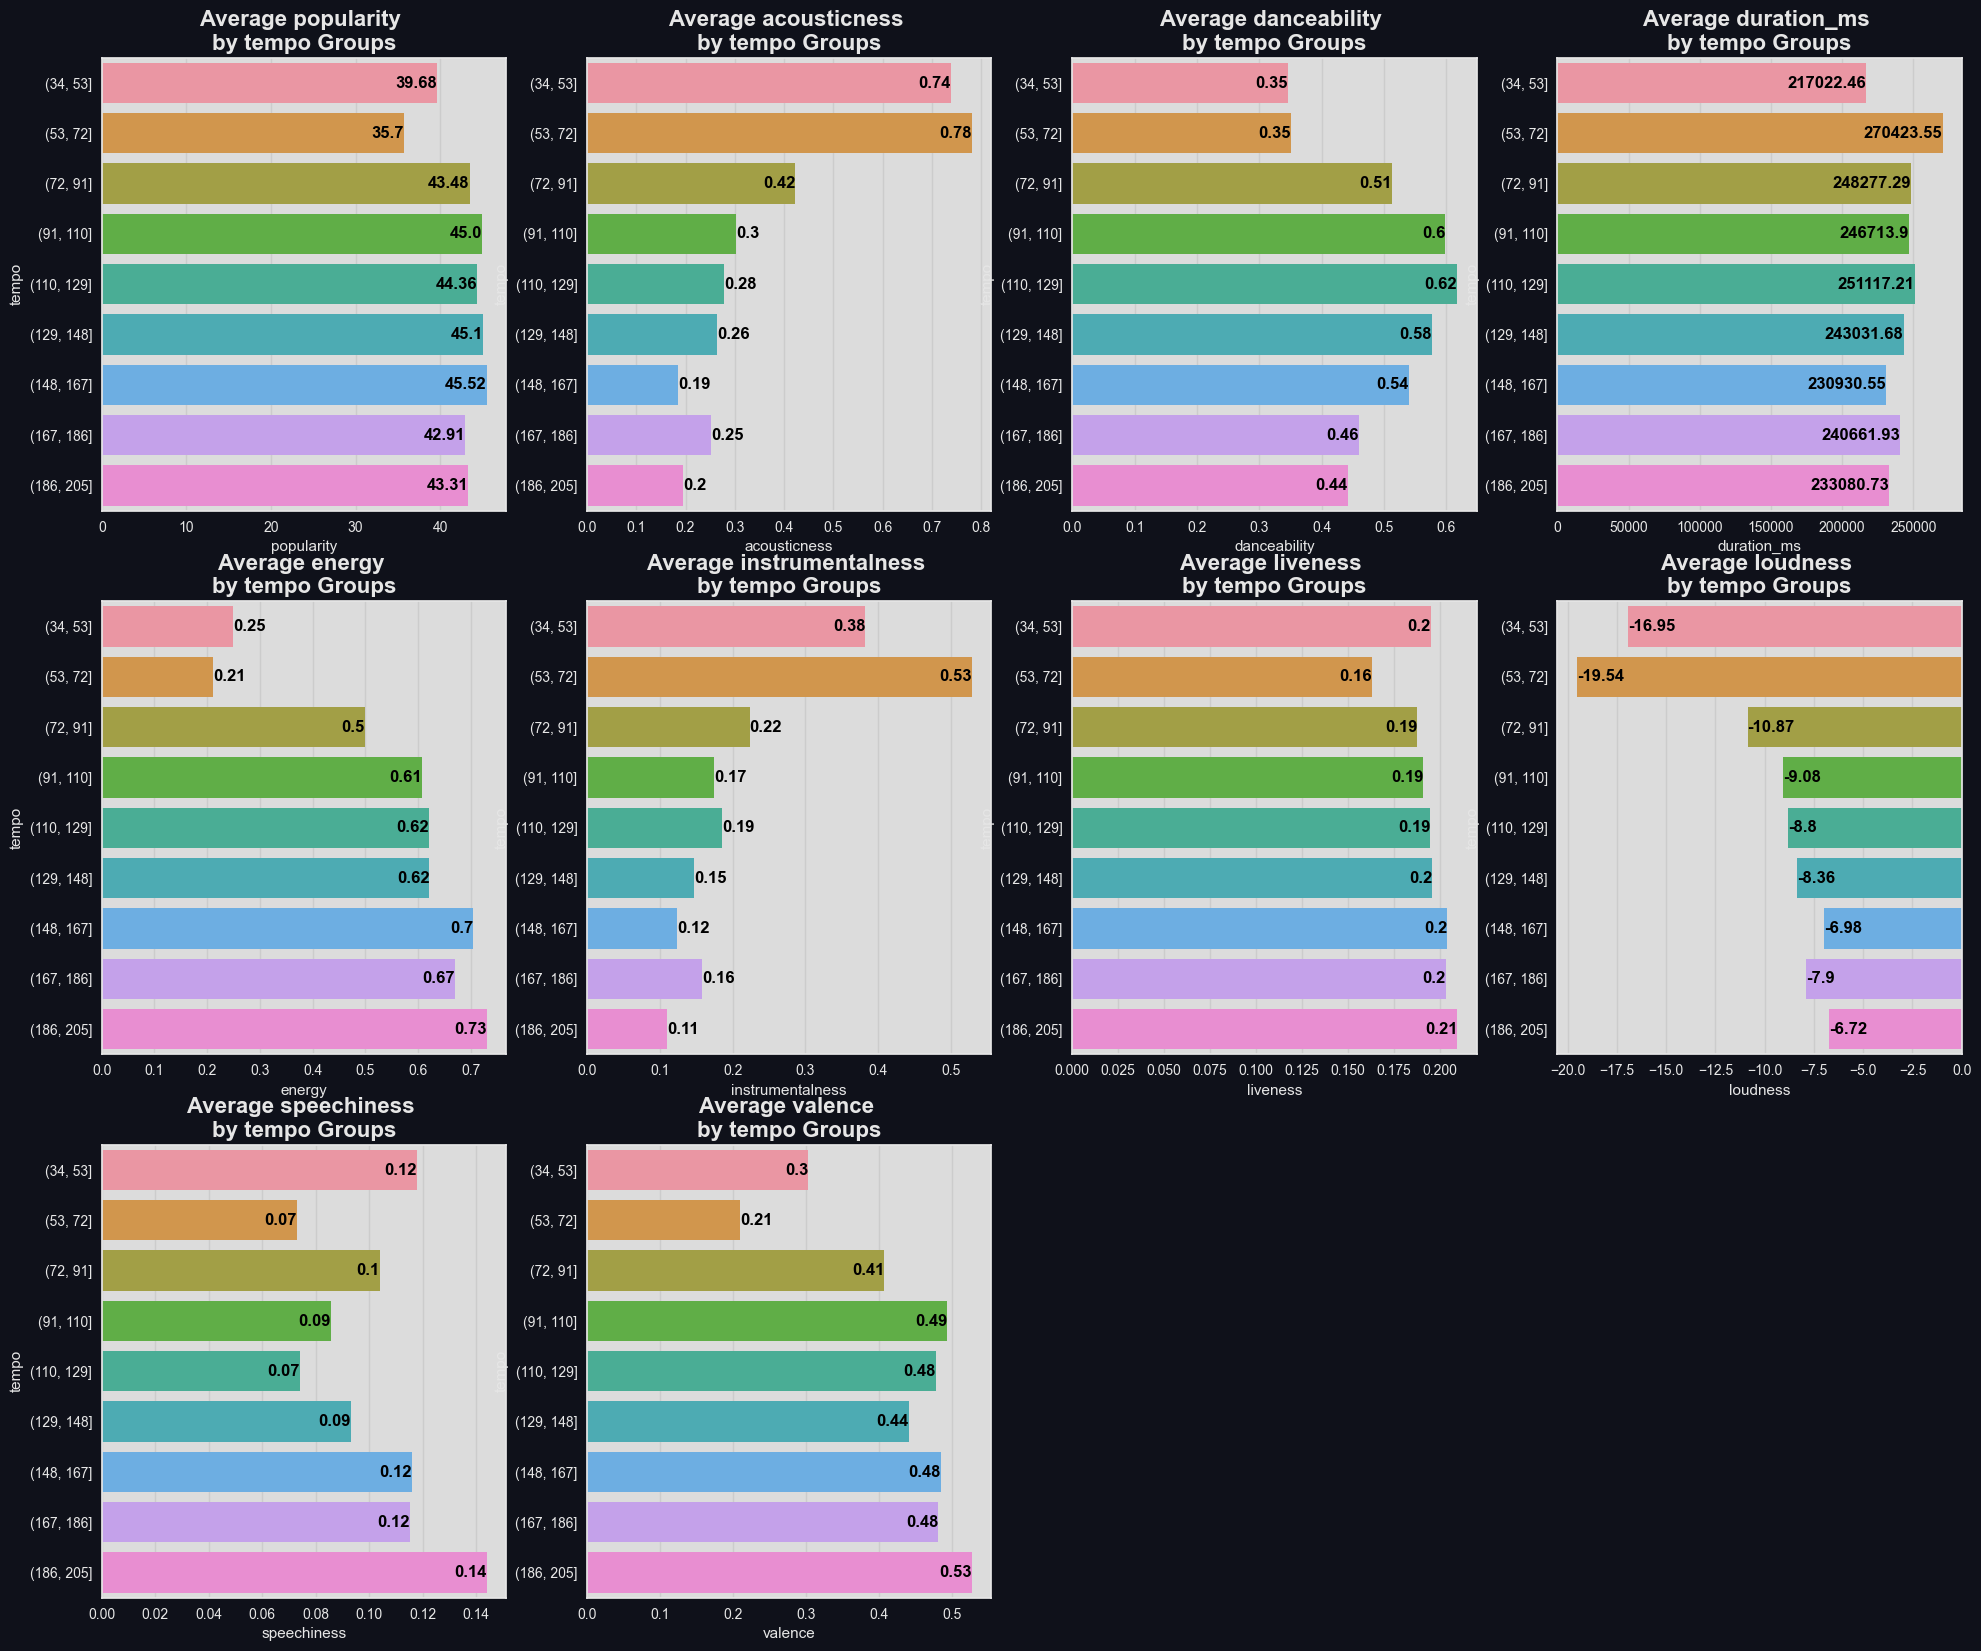

In [30]:
featureBytempoPlot = visualizationof2dataAll(df_visual, 'tempo', [34, 53, 72, 91, 110, 129, 148, 167, 186, 205])

จากกราฟเเท่นด้านบน สามารถสรุปได้ดังนี้
- เพลงที่มีค่า acousticness สูง ค่า tempo ก็จะต่ำ
- เมื่อเพลงมีค่า energy สูง ค่า tempo ก็จะสูงตาม
- เพลงที่ใช้เครื่องดนตรีในการบรรเลงน้อย (instrumentalness) ค่า tempo จะสูง
- เพลงที่มีเสียงดัง (loudness) ค่า tempo จะสูง
- ความนิยมของเพลง (popularity), ความเต้นของเพลง (danceablity), ความยาวเพลง (duration_ms), เพลงที่บันทึกจากการแสดงสด (liveness), เพลงที่มีเสียงร้อง (speechiness), เเละความสูงของเสียง (valence) ไม่ค่อยมีความสัมพันธ์กับ tempo

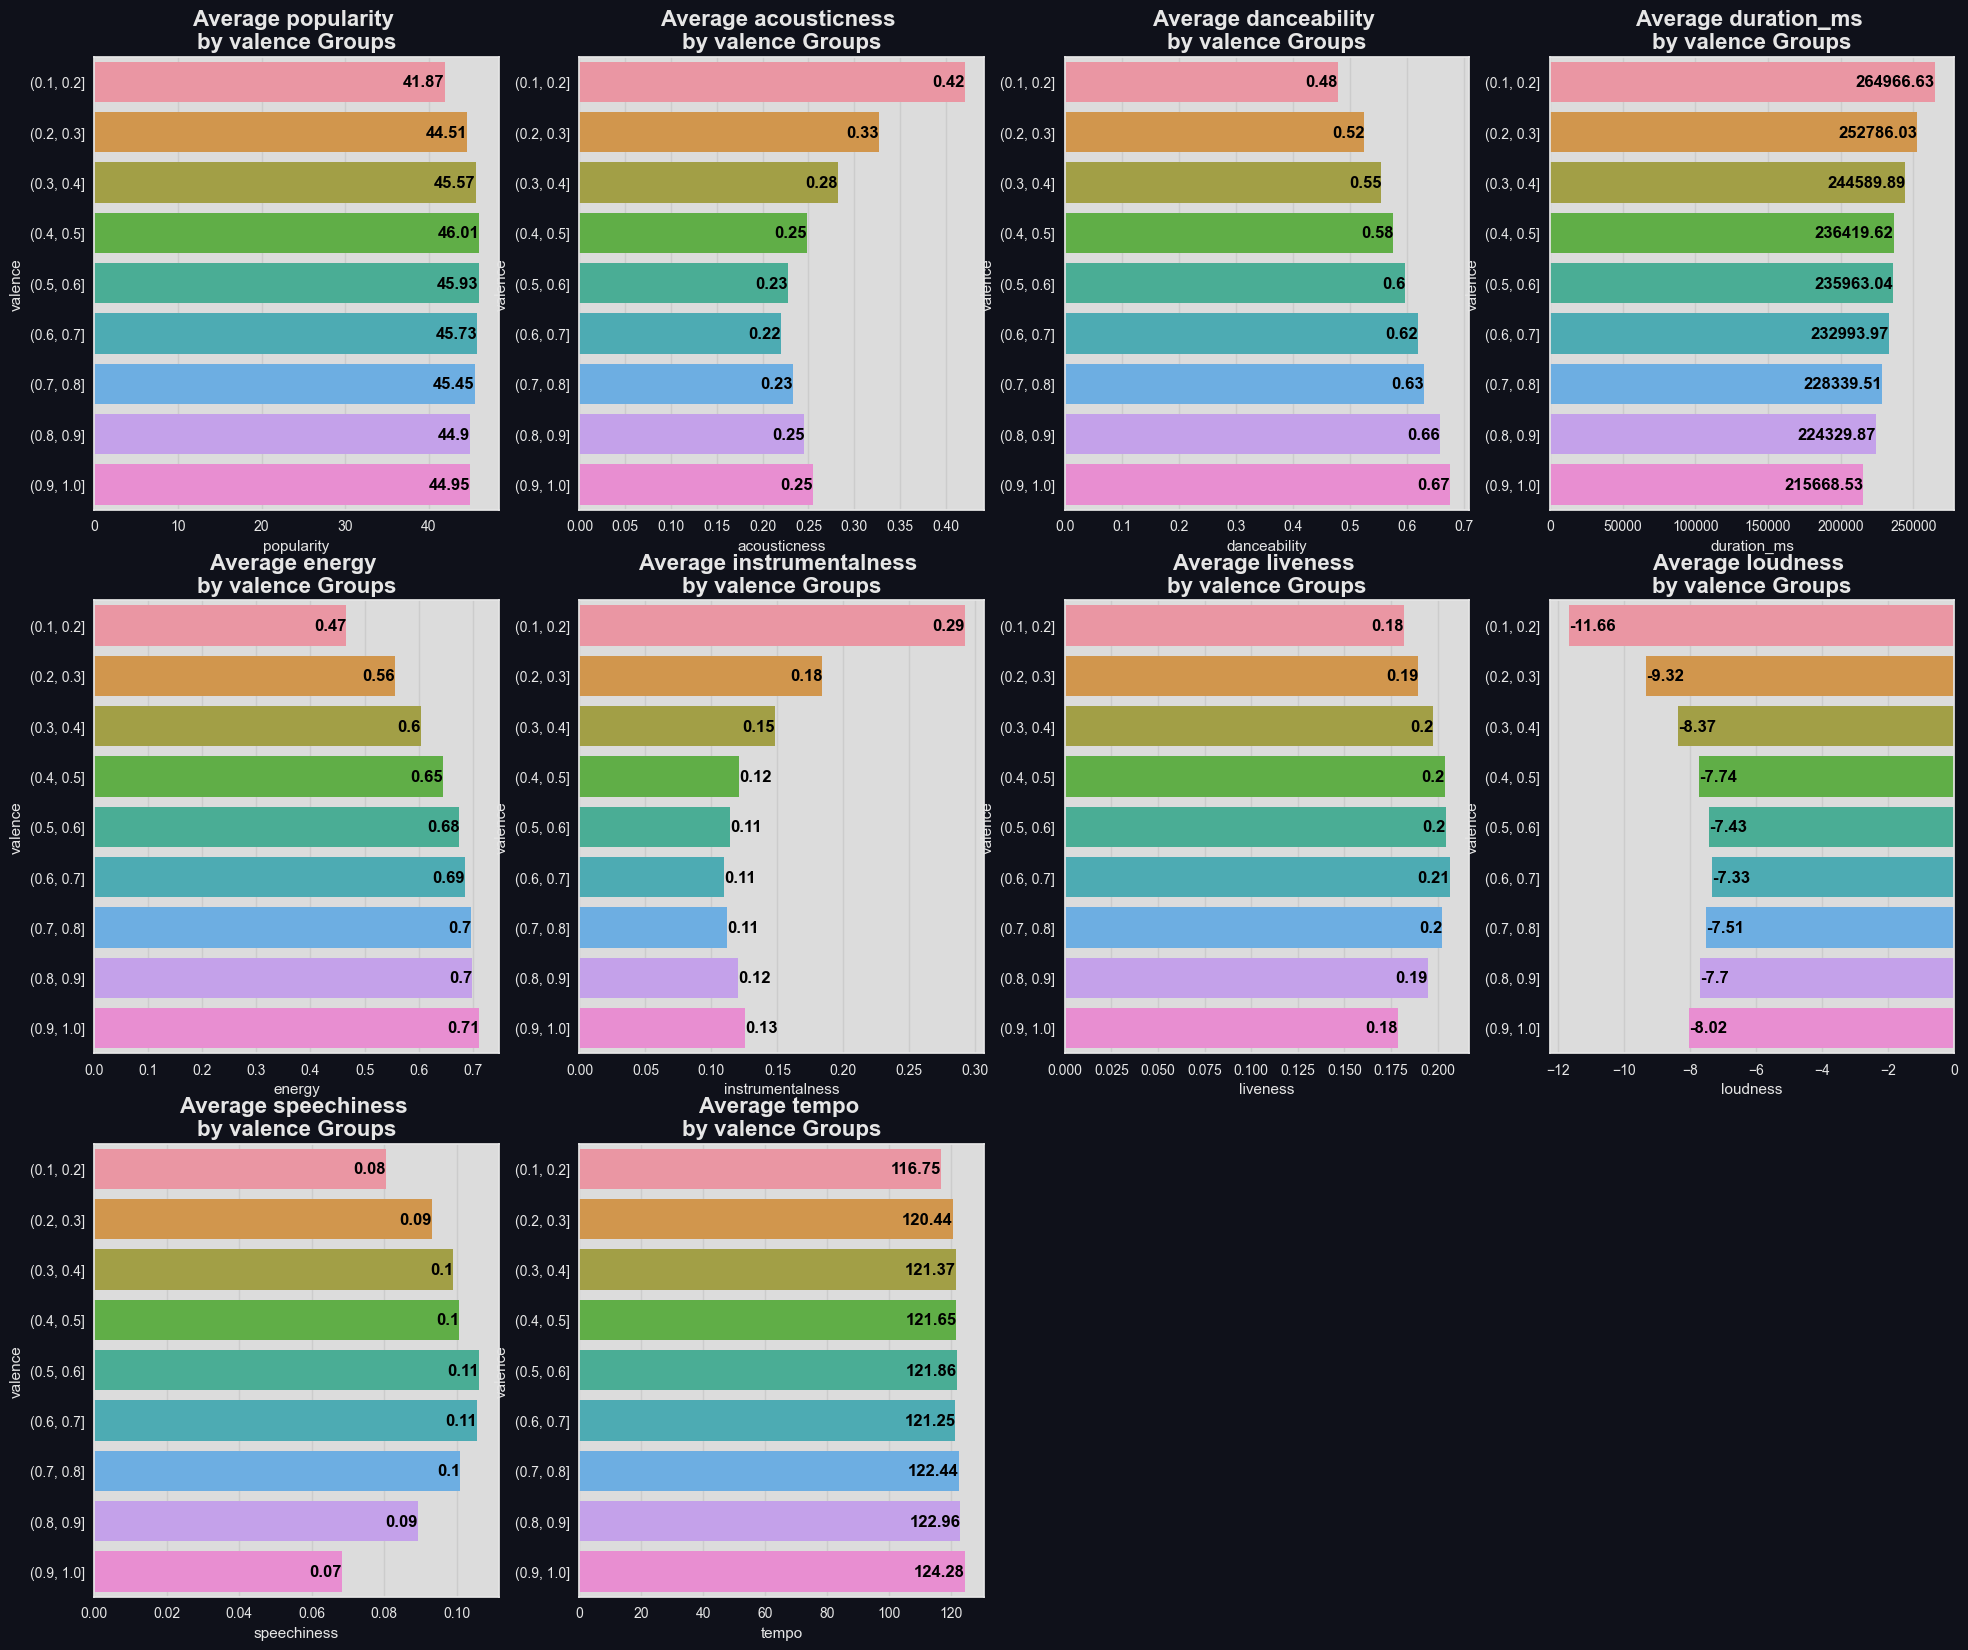

In [31]:
featureByvalencePlot = visualizationof2dataAll(df_visual, 'valence', [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

จากกราฟเเท่นด้านบน สามารถสรุปได้ดังนี้
- เพลงที่มีความ acousticness สูง ค่า valence จะต่ำ
- เมื่อเพลงมีความ danceability สูง ค่า valence จะสูงขึ้นตาม
- เมื่อเพลงมีความยาวมากขึ้น (duration_ms) ค่า valence จะลดลง
- เมื่อเพลงมีความพุ่งของเพลง (energy) สูงขึ้น ค่า valence จะสูงขึ้นตาม
- เพลงที่ใช้เครื่องดนตรีในการบรรเลงเยอะ (instrumentalness) ค่า valence จะต่ำ
- เพลงที่เสียงเบา ค่า valence จะต่ำ
- ความนิยม (popularity), เพลงที่บันทึกจากการแสดงสด (liveness), เพลงที่มีเสียงร้อง (speechiness), เเละจังหวะ (tempo) ไม่ค่อยมีความสัมพันธ์กับ valence

In [ ]:
tempo_mean = music_genre_group['danceability'].mean()

In [ ]:
tempo_meanPlot, axes = plt.subplots(1, 2, figsize=(20, 8))
tempo_meanPlot.suptitle('Mean Tempo by Music Genre', fontsize=20)
tempo_meanPlot.tight_layout(pad=3.0)
sns.barplot(x=tempo_mean.index, y=tempo_mean.values, ax=axes[0])
axes[0].set_title('Mean Tempo by Music Genre', fontsize=15)
axes[0].set_xlabel('Music Genre', fontsize=12)
axes[0].set_ylabel('Mean Tempo', fontsize=12)
axes[0].set_facecolor(axBGColor)
sns.boxplot(x='music_genre', y='tempo', data=df_visual, ax=axes[1], palette=snsPalette)
axes[1].set_title('Tempo Boxplot by Music Genre', fontsize=15)
axes[1].set_xlabel('Music Genre', fontsize=12)
axes[1].set_ylabel('Tempo', fontsize=12)
axes[1].set_facecolor(axBGColor)


In [ ]:
def plotoutlierBarStrip(df,title='',plottype='both',plotdetail='notdetail'):
    df_def = df.copy()
    plotlist = []
    if plottype == 'both' or plottype == 'box':
        if plotdetail == 'notdetail':
            plotgraphBox, axes = plt.subplots(2, 6, figsize=(20, 12))
        elif plotdetail == 'detail':
            plotgraphBox, axes = plt.subplots(2, 6, figsize=(60, 20))
        plotgraphBox.suptitle(f'{title} Outlier Detection', fontsize=20, fontweight='bold', color='white',y=0.92)
        plotgraphBox.delaxes(axes[1,5])
        for idx, col in enumerate(dfNum.columns):
            if plotdetail == 'notdetail':
                sns.boxplot(x=df_def[col],ax=axes[idx//6, idx%6])
            elif plotdetail == 'detail':
                sns.boxplot(x='music_genre', y=col, data=df_def, ax=axes[idx//6, idx%6])
            plt.title(col + ' (box)')
        plotlist.append(plotgraphBox)
    if plottype == 'both' or plottype == 'strip':
        if plotdetail == 'notdetail':
            plotgraphStrip, axes = plt.subplots(2, 6, figsize=(20, 12))
        elif plotdetail == 'detail':
            plotgraphStrip, axes = plt.subplots(2, 6, figsize=(60, 20))
        plotgraphStrip.suptitle(f'{title} Outlier Detection', fontsize=20, fontweight='bold', color='white',y=0.92)
        plotgraphStrip.delaxes(axes[1,5])
        for idx, col in enumerate(dfNum.columns):
            if plotdetail == 'notdetail':
                sns.stripplot(x=df_def[col],ax=axes[idx//6, idx%6])
            elif plotdetail == 'detail':
                sns.stripplot(x='music_genre', y=col, data=df_def, ax=axes[idx//6, idx%6])
            plt.title(col + ' (strip)')
        plotlist.append(plotgraphStrip)
    return plotlist
    

In [ ]:
outlierplotALL = plotoutlierBarStrip(df_visual,'','both','notdetail')

In [ ]:
outlierplotBoxDetail = plotoutlierBarStrip(df_visual,'','box','detail')

In [ ]:
outlierplotstripdetail = plotoutlierBarStrip(df_visual,'','strip','detail')

babababaabababababa

### **Data Exploration's Conclusion**

To conclude everything up to this point, there were <u>4 unnecessary feature</u>, <u>4 duplicated instances</u> and <u>1 missing values</u> that we have removed. This means that we are left with a total of **50000 instances and 14 features**.

In which, there are:

- 4 features, including output, that are '<font color='green'>object</font>', which means that they are '<font color='red'>Categorical Features</font>'.
- 10 features that are '<font color='green'>int64</font>', which means that they are '<font color='red'>Numerical Features</font>'

In [ ]:
df.to_csv('Data/data.csv', index=False)

## **Data Preprocessing**

In [ ]:
df = pd.read_csv('Data/data.csv')
dfNum = df.select_dtypes(include=['float64'])
dfCate = df.select_dtypes(include=['object'])

### **Handle Missing Values**

เนื่องจาก Missing values มีจำนวนมาก 18.8% ของ Dataset ทั้งหมด จึงเลือกที่จะ Replace แทนที่จะ Remove โดยเลือกที่จะ Replace ด้วยค่าต่างในการทดลองนี้โดยเราพิจารณาใช้

- ค่าเฉลี่ยของคอลัมน์ที่มี Missing values
- ค่าที่มีความถี่สูงสุดของคอลัมน์ที่มี Missing values
- Multivariate Imputation by Chained Equations(mice)
- K-Nearest Neighbors (KNN) Imputer

In [ ]:
df_vis = df.copy()
df_impute =  df.copy()

In [ ]:
def plotForImpute(df, feature, df2 = None, prefix = ['','']):
    df = df.copy()
    df_Electronic = df[df['music_genre'] == 'Electronic']
    df_Anime = df[df['music_genre'] == 'Anime']
    df_Jazz = df[df['music_genre'] == 'Jazz']
    df_Alternative = df[df['music_genre'] == 'Alternative']
    df_Country = df[df['music_genre'] == 'Country']
    df_Blues = df[df['music_genre'] == 'Blues']
    df_Rap = df[df['music_genre'] == 'Rap']
    df_Rock = df[df['music_genre'] == 'Rock']
    df_Classical = df[df['music_genre'] == 'Classical']
    df_Hip_Hop = df[df['music_genre'] == 'Hip-Hop']
    if type(df2) == type(None):
        plotDflist = [df_Electronic, df_Anime, df_Jazz, df_Alternative, df_Country, df_Blues, df_Rap, df_Rock, df_Classical, df_Hip_Hop]
        titlelist = ['Electronic', 'Anime', 'Jazz', 'Alternative', 'Country', 'Blues', 'Rap', 'Rock', 'Classical', 'Hip-Hop']
        row , col = 2, 5
        targetPlot = feature
        imputeHists, axes = plt.subplots(row, col, figsize=(30, 10))
    else :
        df2 = df2.copy()
        df2_Electronic = df2[df2['music_genre'] == 'Electronic']
        df2_Anime = df2[df2['music_genre'] == 'Anime']
        df2_Jazz = df2[df2['music_genre'] == 'Jazz']
        df2_Alternative = df2[df2['music_genre'] == 'Alternative']
        df2_Country = df2[df2['music_genre'] == 'Country']
        df2_Blues = df2[df2['music_genre'] == 'Blues']
        df2_Rap = df2[df2['music_genre'] == 'Rap']
        df2_Rock = df2[df2['music_genre'] == 'Rock']
        df2_Classical = df2[df2['music_genre'] == 'Classical']
        df2_Hip_Hop = df2[df2['music_genre'] == 'Hip-Hop']
        plotDflist = [df_Electronic, df2_Electronic, df_Anime, df2_Anime, df_Jazz, df2_Jazz, df_Alternative, df2_Alternative, df_Country, df2_Country, df_Blues, df2_Blues, df_Rap, df2_Rap, df_Rock, df2_Rock, df_Classical, df2_Classical, df_Hip_Hop, df2_Hip_Hop]
        titlelist = ['Electronic', 'Electronic', 'Anime', 'Anime', 'Jazz', 'Jazz', 'Alternative', 'Alternative', 'Country', 'Country', 'Blues', 'Blues', 'Rap', 'Rap', 'Rock', 'Rock', 'Classical', 'Classical', 'Hip-Hop', 'Hip-Hop']
        row , col = 5, 2
        targetPlot = feature
        imputeHists, axes = plt.subplots(2*row, col, figsize=(20, 60))
    for i, df in enumerate(plotDflist):
            ax = axes[i//col, i%col]
            sns.histplot(df[targetPlot], ax=ax, color=snsPalette[0], kde=True)
            if i%2 == 0:
                ax.set_title(f'{prefix[0]}'+titlelist[i])
            else:
                ax.set_title(f'{prefix[1]}'+titlelist[i])
            ax.set_xlabel(targetPlot)
            ax.set_ylabel('Count')
            ax.set_facecolor(axBGColor)
    return imputeHists

#### **Plotting Histogram**

In [ ]:
imputeHists_tempo = plotForImpute(df_vis, 'tempo')

In [ ]:
imputeHists_duration_ms = plotForImpute(df_vis, 'duration_ms')

โดยเราจะ Plot Histogram ของคอลัมน์ที่มี Missing values ออกมาเพื่อพิจารณาการกระจายของตัวของข้อมูล โดยเราจะพยายามที่จะเลือก Method ในการ Replace ที่มีการกระจายของข้อมูลใกล้เคียงกับข้อมูลตั้งต้นมากที่สุดเพื่อไม่ให้การทำ Imputation ทำให้ข้อมูลไมาแสดงถึงการกระจายของข้อมูลจริง 

#### **Imputation Using Mean,Most Frequent**

In [ ]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
df_impute_mean = df_impute.copy()
df_impute_mean['tempo'] = imp_mean.fit_transform(df_impute_mean[['tempo']])
df_impute_mean['duration_ms'] = imp_mean.fit_transform(df_impute_mean[['duration_ms']])
imputeHists_mean_tempo_compare = plotForImpute(df_vis , 'tempo', df_impute_mean, ['Original ','Imputed '])
imputeHists_mean_duration_ms_compare = plotForImpute(df_vis , 'duration_ms', df_impute_mean, ['Original ','Imputed '])

In [ ]:
imp_mode = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
df_impute_mode = df_impute.copy()
df_impute_mode['tempo'] = imp_mode.fit_transform(df_impute_mode[['tempo']])
df_impute_mode['duration_ms'] = imp_mode.fit_transform(df_impute_mode[['duration_ms']])
imputeHists_mode_tempo_compare = plotForImpute(df_vis , 'tempo', df_impute_mode, ['Original ','Imputed '])
imputeHists_mode_duration_ms_compare = plotForImpute(df_vis , 'duration_ms', df_impute_mode, ['Original ','Imputed '])

From the histogram, we can see that the distribution of the data is not quite the same as before. So we decided not to use the mean and the most frequent value to impute the missing values.

#### **Imputation Using Multivariate Imputation by Chained Equations(mice)**

In [ ]:
from impyute.imputation.cs import mice

df_impute_mice = df_impute.copy()
df_impute_mice.drop(['music_genre','key','mode'], axis=1, inplace=True)
imputed_training=mice(df_impute_mice.values)

In [ ]:
df_impute_mice = pd.DataFrame(imputed_training, columns=df_impute_mice.columns)
df_impute_mice['key'] = df_impute['key']
df_impute_mice['mode'] = df_impute['mode']
df_impute_mice['music_genre'] = df_impute['music_genre']
df_impute_mice

In [ ]:
imputeHists_mice_tempo_compare = plotForImpute(df_vis , 'tempo', df_impute_mice, ['Original ','Imputed '])

In [ ]:
imputeHists_mice_duration_ms_compare = plotForImpute(df_vis , 'duration_ms', df_impute_mice, ['Original ','Imputed '])

From the histogram, we can see that the distribution of the data is quite the same as before. So we decided to use the mice to impute the missing values.

#### **Imputation Using KNNImputer**

##### **Search for Hyperparameter**

In [ ]:
# Impute missing values
df_impute_knn_find = df_impute.copy()
df_impute_knn_find = pd.get_dummies(df_impute_knn_find, columns=['key','mode'], drop_first=True).dropna()

In [ ]:
X = df_impute_knn_find.drop(['music_genre'], axis=1)
y = df_impute_knn_find['music_genre']
colX = X.columns
toend = ['Electronic', 'Anime', 'Jazz', 'Alternative', 'Country', 'Rap',
       'Blues', 'Rock', 'Classical', 'Hip-Hop']
coltoend = [['music_genre']]
y = y.apply(lambda x: toend.index(x))
scaler = StandardScaler()
X = scaler.fit_transform(X)

KN_param = [{ 'n_neighbors' : range(0,6,1),
             'weights' : ['uniform', 'distance'],
              }]

KN_clf = KNeighborsClassifier(n_jobs=-1)

f1sc = make_scorer(f1_score, average='weighted')

grid_KN_clf = GridSearchCV(KN_clf, 
                        KN_param,
                        scoring=f1sc, 
                        refit=True,
                        cv=4,
                        n_jobs=-1,
                        verbose=3,
                        return_train_score=True)

In [ ]:
# grid_KN_clf.fit(X, y)
# print("tuned hpyerparameters :(best parameters) ",grid_KN_clf.best_params_)
# print("score :",grid_KN_clf.best_score_)

"""
Fitting 4 folds for each of 12 candidates, totalling 48 fits
tuned hpyerparameters :(best parameters)  {'n_neighbors': 3, 'weights': 'uniform'}
score : 0.41099356419921224

Fitting 4 folds for each of 12 candidates, totalling 48 fits
tuned hpyerparameters :(best parameters)  {'n_neighbors': 5, 'weights': 'uniform'}
score : 0.4450642884772404

Fitting 4 folds for each of 22 candidates, totalling 88 fits
tuned hpyerparameters :(best parameters)  {'n_neighbors': 10, 'weights': 'uniform'}
score : 0.4686828275311239

Fitting 4 folds for each of 22 candidates, totalling 88 fits
tuned hpyerparameters :(best parameters)  {'n_neighbors': 30, 'weights': 'uniform'}
score : 0.4754055746692795
"""

โดยหลังจากที่นำค่า K ที่เป็นไปได้มาทดลองแล้ว จะพบว่า ค่า K ที่ดีที่สุดคือ 3 ที่จะใช้ Histogram ในการทำ Imputation ให้มีการกระจายของข้อมูลใกล้เคียงกับข้อมูลตั้งต้นมากที่สุด ทั้งนี้ด้วยความที่ KNN เป็น Model ที่ได้รับผลกระทบจาก Outlier ค่อนข้างมากเมื่อ K เพิ่มขึ้น ด้วยเหตุที่ว่า มี Bias ที่สูงและ Variance ที่ต่ำ จึงเลือกใช้ K ที่เล็กที่สุด 3 ในการทำ Imputation

##### **Impute**

In [ ]:
# Impute missing values
df_impute_knn = df_impute.copy()
df_impute_knn = pd.get_dummies(df_impute_knn, columns=['key','mode','music_genre'], drop_first=True)
col_knn = df_impute_knn.columns

In [ ]:
scaler_knnimpute = StandardScaler()
df_impute_knn = pd.DataFrame(scaler_knnimpute.fit_transform(df_impute_knn), columns=col_knn)
KNNimputer = KNNImputer(n_neighbors=3, weights="uniform")
df_impute_knn = pd.DataFrame(KNNimputer.fit_transform(df_impute_knn), columns=col_knn)
df_impute_knn = pd.DataFrame(scaler_knnimpute.inverse_transform(df_impute_knn), columns=col_knn)

In [ ]:
duration_ms = df_impute_knn['duration_ms']
tempo = df_impute_knn['tempo']
df_impute_knn = df_impute.copy()
df_impute_knn['duration_ms'] = duration_ms
df_impute_knn['tempo'] = tempo
df_impute_knn

In [ ]:
imputeHists_KNN_tempo_compare = plotForImpute(df_vis , 'tempo', df_impute_knn, ['Original ','Imputed '])

In [ ]:
imputeHists_KNN_duration_ms_compare = plotForImpute(df_vis , 'duration_ms', df_impute_knn, ['Original ','Imputed '])

From the histogram, we can see that the distribution of the data is quite the same as before. So we decided to use the KNNImputer to impute the missing values.

#### **Conclusion**

เนื่องจากการทำ Imputation ด้วย KNNImputer และ mice ได้ผลลัพธ์ที่ใกล้เคียงกับข้อมูลตั้งต้นมาก เราจะพิจารณาถึง Histogram ของข้อมูลโดยรวมและ Outlier ของข้อมูลเพิ่มเติม

In [ ]:
coltoplot = ['duration_ms','tempo']
dftoplot = [df_vis, df_impute_mice, df_impute_knn]
titlelist = ['Original','MICE','KNN']
NumHists_knn, axes = plt.subplots(2, 3, figsize=(15, 10))
for i, df in enumerate(dftoplot):
    for j, col in enumerate(coltoplot):
        ax = axes[j, i]
        sns.histplot(df[col], ax=ax, color=snsPalette[0], kde=True)
        ax.set_title(f'{col} '+titlelist[i])
        ax.set_xlabel(col)
        ax.set_ylabel('Count')
        ax.set_facecolor(axBGColor)

In [ ]:
outlierplotstripOriginal = plotoutlierBarStrip(df_vis, 'Original','strip','notdetail')

In [ ]:
outlierplotstripMice = plotoutlierBarStrip(df_impute_mice, 'KNN Impute','strip','notdetail')

In [ ]:
outlierplotstripKNNimpute = plotoutlierBarStrip(df_impute_knn, 'KNN Impute','strip','notdetail')

หลังจากพิจารณา Histogram ของข้อมูลโดยรวมและ Outlier ของข้อมูลแล้วพอว่าผลลัพธ์ที่ได้จากการทำ Imputation ด้วย KNNImputer มีความถูกต้องมากกว่าการทำ Imputation ด้วย Mean, Most Frequent และ mice จึงเลือกใช้ KNNImputer ในการทำ Imputation เป็นผลลัพธ์สุดท้าย

In [ ]:
df_impute_knn.to_csv('Data/df_impute_knn.csv', index=False)

### **Remove Outlier**

In [ ]:
def modelTestProcess(df, getdummy = 0):
    df_model = df.copy()
    if getdummy == 1:
        df_model = pd.get_dummies(df_model, columns=['mode','key'],drop_first=True)
    X = df_model.drop(['music_genre'], axis=1)
    y = df_model['music_genre']
    # Scaling
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    # Splitting
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    # Model
    LR_clf = LogisticRegression(n_jobs=-1, random_state=1,multi_class='multinomial')
    DT_clf = DecisionTreeClassifier(random_state=1)
    RF_clf = RandomForestClassifier(n_jobs=-1, random_state=1)
    KNN_clf = KNeighborsClassifier(n_jobs=-1)
    MLPC_clf = MLPClassifier(random_state=1)
    # SVC_clf = LinearSVC(random_state=1,multi_class='crammer_singer')
    modeldict = {'Logistic Regression Model':LR_clf, 'Decision Tree Model':DT_clf, 'Random Forest Model':RF_clf,
                'KNN Model':KNN_clf, 'MLPC Model':MLPC_clf}
    # Training
    for modelname, model in modeldict.items():
        model.fit(X_train, y_train)
        print(f'{modelname} trained.')
    # Testing
    resultdict = {}
    confusion_matrix_dict = {}
    f1scoredict = {}
    for modelname, model in modeldict.items():
        y_pred = model.predict(X_test)
        resultdict[modelname] = classification_report(y_test, y_pred)
        confusion_matrix_dict[modelname] = confusion_matrix(y_test, y_pred)
        f1scoredict[modelname] = f1_score(y_test, y_pred, average='weighted')
    for key, value in resultdict.items():
        print(f'Classification report of {key}',':\n',value)
        print(f'F1 score of {key} is {f1scoredict[key]}\n','-'*50)
    return modeldict,resultdict,confusion_matrix_dict,f1scoredict

In [ ]:
df = pd.read_csv('Data/df_impute_knn.csv')
dfNum = df.select_dtypes(include=['float64'])
dfCate = df.select_dtypes(include=['object'])
dfOutlier = df.copy()
df.head()

##### **Performance Benchmark**

In [ ]:
modelBM, resultBM, confmatrixBM, f1BM = modelTestProcess(df, getdummy=1)

We will be removing the outliers from the dataset using Anomaly Detection with Isolation Forest Algorithm, Local Outlier Factor Algorithm and KNN Algorithm.

#### **Isolation Forest**

In [ ]:
from sklearn.ensemble import IsolationForest

In [ ]:
dfOutlier_IF = dfOutlier.copy()
dfOutlier_IF = pd.get_dummies(dfOutlier_IF, columns=['key','mode'], drop_first=True)
dfOutlier_IF.head()

##### **Search for Hyperparameter**

In [ ]:
IF_clf = IsolationForest(n_jobs=-1, random_state=1)
X = dfOutlier_IF.drop(['music_genre'], axis=1)
y = dfOutlier_IF['music_genre']
toend = ['Electronic', 'Anime', 'Jazz', 'Alternative', 'Country', 'Rap',
       'Blues', 'Rock', 'Classical', 'Hip-Hop']
coltoend = [['music_genre']]
y = y.apply(lambda x: toend.index(x))

param_grid = {'n_estimators': list(range(100, 1100, 100)), 
              # 'max_samples': list(range(100, 500, 5)), 
              # 'contamination': [0.1, 0.2, 0.3, 0.4, 0.5], 
              'max_features': [15,20],
              }

f1sc = make_scorer(f1_score, average='weighted')

grid_dt_estimator = GridSearchCV(IF_clf, 
                                param_grid,
                                scoring=f1sc, 
                                refit=True,
                                cv=4,
                                n_jobs=-1,
                                verbose=3,
                                return_train_score=True)

In [ ]:
# grid_dt_estimator.fit(X, y)
# print("tuned hpyerparameters :(best parameters) ",grid_dt_estimator.best_params_)
# print("score :",grid_dt_estimator.best_score_)

'''
Fitting 4 folds for each of 15 candidates, totalling 60 fits
tuned hpyerparameters :(best parameters)  {'max_features': 15, 'n_estimators': 140}
score : 0.05262386217850815

Fitting 4 folds for each of 18 candidates, totalling 72 fits
tuned hpyerparameters :(best parameters)  {'max_features': 15, 'n_estimators': 150}
score : 0.05270171149144254

Fitting 4 folds for each of 20 candidates, totalling 80 fits
tuned hpyerparameters :(best parameters)  {'max_features': 20, 'n_estimators': 100}
score : 0.05414193867457961
'''

##### **Remove outlier**

In [ ]:
clf=IsolationForest(n_estimators=100, max_samples='auto', contamination='auto',max_features=20, bootstrap=False, n_jobs=-1, random_state=1, verbose=2)
clf.fit(dfOutlier_IF.drop(['music_genre'], axis=1))

pred = clf.predict(dfOutlier_IF.drop(['music_genre'], axis=1))
dfOutlier_IF['anomaly']=pred
outliers=dfOutlier_IF.loc[dfOutlier_IF['anomaly']==-1]
outlier_index=list(outliers.index)
print(len(outlier_index))
print(dfOutlier_IF['anomaly'].value_counts())

In [ ]:
df_outliertest_IF = dfOutlier_IF[dfOutlier_IF['anomaly']==1].drop(['anomaly'], axis=1)
df_outliertest_IF.info()

In [ ]:
outlierplotboxALL, axes = plt.subplots(2, 6, figsize=(20, 12))
outlierplotboxALL.delaxes(axes[1,5])
for idx, col in enumerate(dfNum.columns):
    sns.boxplot(x=df_outliertest_IF[col],ax=axes[idx//6, idx%6])
    plt.title(col + ' (box)')
outlierplotstripALL, axes = plt.subplots(2, 6, figsize=(20, 12))
outlierplotstripALL.delaxes(axes[1,5])
for idx, col in enumerate(dfNum.columns):
    sns.stripplot(x=df_outliertest_IF[col],ax=axes[idx//6, idx%6])
    plt.title(col + ' (strip)')

##### **Performance**

In [ ]:
modelBM_IF, resultBM_IF, confmatrixBM_IF, f1BM_IF = modelTestProcess(df_outliertest_IF, getdummy=0)

#### **Local Outlier Factor**

In [ ]:
from sklearn.neighbors import LocalOutlierFactor
dfOutlier_LOF = dfOutlier.copy()
dfOutlier_LOF = pd.get_dummies(dfOutlier_LOF, columns=['key','mode'], drop_first=True)
dfOutlier_LOF

##### **Search for Hyperparameter**

In [ ]:
# Impute missing values
dfOutlier_LOF_find = dfOutlier_LOF.copy()
X = dfOutlier_LOF_find.drop(['music_genre'], axis=1)
y = dfOutlier_LOF_find['music_genre']
colX = X.columns
toend = ['Electronic', 'Anime', 'Jazz', 'Alternative', 'Country', 'Rap',
       'Blues', 'Rock', 'Classical', 'Hip-Hop']
coltoend = [['music_genre']]
y = y.apply(lambda x: toend.index(x))
scalerLOF = StandardScaler()
X = scalerLOF.fit_transform(X)

KN_LOF_param = [{ 
              'n_neighbors' : range(10,60,10),
              # 'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
              # 'leaf_size' : range(10,60,10),
              }]

KN_LOF_clf = KNeighborsClassifier(n_jobs=-1,algorithm='ball_tree')

f1sc = make_scorer(f1_score, average='weighted')

grid_KN_LOF_clf = GridSearchCV(KN_LOF_clf, 
                        KN_LOF_param,
                        scoring=f1sc, 
                        refit=True,
                        cv=4,
                        n_jobs=-1,
                        verbose=3,
                        return_train_score=True)

In [ ]:
# grid_KN_LOF_clf.fit(X, y)
# print("tuned hpyerparameters :(best parameters) ",grid_KN_LOF_clf.best_params_)
# print("score :",grid_KN_LOF_clf.best_score_)

"""
Fitting 4 folds for each of 4 candidates, totalling 16 fits
tuned hpyerparameters :(best parameters)  {'algorithm': 'ball_tree'}
score : 0.4638039248476319

Fitting 4 folds for each of 5 candidates, totalling 20 fits
tuned hpyerparameters :(best parameters)  {'n_neighbors': 20}
score : 0.4852892750123391
"""

##### **Remove outlier**

In [ ]:
X = dfOutlier_LOF.drop(['music_genre'], axis=1)
colX = X.columns
y = dfOutlier_LOF['music_genre']

scalerLOF = StandardScaler()
X = scalerLOF.fit_transform(X)
clf = LocalOutlierFactor(n_neighbors=20, algorithm='ball_tree', n_jobs=-1)
clf.fit_predict(X)
lof  = clf.negative_outlier_factor_

In [ ]:
thresh = np.quantile(lof, .03)
print(thresh)

In [ ]:
outlier = X[lof <= thresh]
newdata = X[lof > thresh]

In [ ]:
df_all = pd.DataFrame(X, columns=colX)
df_all['music_genre'] = y
dfOutlier_LOF = pd.DataFrame(outlier, columns=colX)
dfOutlier_LOF['music_genre'] = y.to_numpy()[lof <= thresh]
df_new = pd.DataFrame(newdata, columns=colX)
df_new['music_genre'] = y.to_numpy()[lof > thresh]
df_new

In [ ]:
outlierplotstripALL, axes = plt.subplots(2, 6, figsize=(20, 12))
outlierplotstripALL.delaxes(axes[1,5])
for idx, col in enumerate(dfNum.columns):
    sns.stripplot(x=df_all[col],ax=axes[idx//6, idx%6])
    plt.title(col + ' (strip)')

In [ ]:
outlierplotstripALL, axes = plt.subplots(2, 6, figsize=(20, 12))
outlierplotstripALL.delaxes(axes[1,5])
for idx, col in enumerate(dfNum.columns):
    sns.stripplot(x=df_new[col],ax=axes[idx//6, idx%6])
    plt.title(col + ' (strip)')

In [ ]:
outlierplotstrip, axes = plt.subplots(2, 6, figsize=(60, 20))
outlierplotstrip.delaxes(axes[1,5])
for idx, col in enumerate(dfNum.columns):
    sns.stripplot(x='music_genre', y=col, data=df_new, ax=axes[idx//6, idx%6])
    plt.title(col + ' (strip)')

##### **Performance**

In [ ]:
modelBM_LOF, resultBM_LOF, confmatrixBM_LOF, f1BM_LOF = modelTestProcess(df_new, getdummy=0)
print(f1BM_LOF)

#### **k-Nearest Neighbors**

In [ ]:
# create arrays
dfnbrs = dfOutlier.copy()
dfnbrs = pd.get_dummies(dfnbrs, columns=['key','mode'], drop_first=True)
X = dfnbrs.drop(['music_genre'], axis=1).values
y = dfnbrs['music_genre']